In [41]:
from typing import Optional
from dataclasses import dataclass
import cv2
import polars as pl
from IPython.display import Image, display
from collections.abc import Iterable
from typing import Any, Generator
import numpy as np
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go

# Image analysis 

In [2]:
@dataclass
class Color:
    """
    RGB color represented as integers in the range [0, 255].
    """
    r: int
    g: int
    b: int

    def __post_init__(self):
        assert 0 <= self.r <= 255
        assert 0 <= self.g <= 255
        assert 0 <= self.b <= 255

    def to_bgr_tuple(self) -> tuple[int, int, int]:
        return self.b, self.g, self.r


@dataclass
class Point:
    """
    A class representing a point in a 2D grid. r is the row index, c is the column index.
    """
    r: int
    c: int


def validate_point(point: Point, img):
    """Check if the point is within the image boundaries"""
    img_height, img_width, _ = img.shape
    if not (0 <= point.r < img_height and 0 <= point.c < img_width):
        raise ValueError(
            f"Point ({point.r}, {point.c}) is outside the image boundaries. Image size: {img_width}x{img_height}")


def get_pixel_color(point: Point, img) -> Color:
    """Get color of the pixel at the given image"""
    validate_point(point, img)
    b, g, r = img[point.r, point.c]
    return Color(int(r), int(g), int(b))  # Convert to RGB for consistency


def update_pixel_color(point: Point, img, color: Color):
    """Update the color of the pixel at the given image, return updated image"""
    validate_point(point, img)
    img[point.r, point.c] = color.to_bgr_tuple()
    return img


[[Point(r=100, c=280), Point(r=100, c=304), Point(r=100, c=328), Point(r=100, c=352), Point(r=100, c=376)], [Point(r=124, c=280), Point(r=124, c=304), Point(r=124, c=328), Point(r=124, c=352), Point(r=124, c=376)], [Point(r=148, c=280), Point(r=148, c=304), Point(r=148, c=328), Point(r=148, c=352), Point(r=148, c=376)], [Point(r=172, c=280), Point(r=172, c=304), Point(r=172, c=328), Point(r=172, c=352), Point(r=172, c=376)], [Point(r=196, c=280), Point(r=196, c=304), Point(r=196, c=328), Point(r=196, c=352), Point(r=196, c=376)], [Point(r=220, c=280), Point(r=220, c=304), Point(r=220, c=328), Point(r=220, c=352), Point(r=220, c=376)]]
(280, 512, 3)


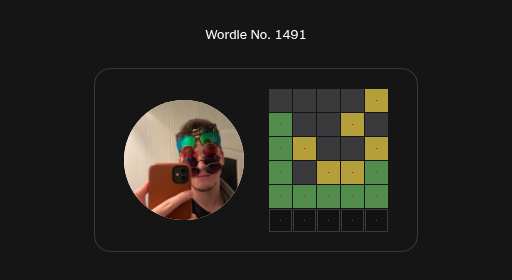

In [42]:


def get_cell_coordinates(first_cell_pos: Point, matrix_size: tuple[int, int], intercell_interval_px: int,
                         cell_size_px: Point) -> list[list[Point]]:
    """Generate list of coordinates of all cells in the matrix"""
    return [
        [Point(first_cell_pos.r + (intercell_interval_px + cell_size_px.r) * j,
               first_cell_pos.c + (intercell_interval_px + cell_size_px.c) * i) for i in range(matrix_size[1])]
        for j in range(matrix_size[0])
    ]


def flatten(nested: Iterable[Any]) -> Generator[Any, None, None]:
    """Recursively flatten any nested iterable into a flat generator."""
    for item in nested:
        if isinstance(item, Iterable) and not isinstance(item, (str, bytes)):
            yield from flatten(item)
        else:
            yield item

# get coordinates using https://pixspy.com/
cell_size_px = Point(23, 23)  # size of each cell in pixels
intercell_interval_px = 1  # space between cells in pixel
matrix_size = (6, 5)  # number of cells in each direction (rows, columns)

first_cell_pos = Point(100, 280)  # middle of the top left corner cell
# first_cell_pos = Point(89, 269)  # top left corner of the top left cell


cell_coordinates = get_cell_coordinates(
    first_cell_pos=first_cell_pos,
    matrix_size=matrix_size,
    intercell_interval_px=intercell_interval_px,
    cell_size_px=cell_size_px
)

print(cell_coordinates)

test_file = "imgs/2025-07-19T12:19:04.279000+00:00.png"
test_img = cv2.imread(test_file)
red = Color(255, 0, 0)
print(test_img.shape)

for point in flatten(cell_coordinates):
    # update the image by adding red pixel in the middle of each cell
    update_pixel_color(point, test_img, red)

cv2.imwrite("test_bruh.png", test_img)
display(Image(filename="test_bruh.png"))


In [43]:
from copy import deepcopy

correct_place_color = Color(83, 141, 78)
correct_letter_color = Color(181, 159, 59)
wrong_letter_color = Color(58, 58, 60)
empty_color = Color(18, 18, 19)


def print_matrix(matrix: list[list]):
    for row in matrix:
        print(''.join(str(elem) for elem in row))


def get_wordle_matrix(img, cell_coordinates: list[list[Point]], output_type: str = "str") -> list[list[str]] | list[list[float]]:
    matrix = deepcopy(
        cell_coordinates)  # using the same matrix as before but now instead of coordinates we will get the cell color
    for r, row in enumerate(cell_coordinates):
        for c, point in enumerate(row):
            cell_color = get_pixel_color(point, img)
            cell_color_emoji: str
            match cell_color:
                case _ if cell_color == correct_place_color:
                    cell_color_emoji = "üü©" if output_type == "str" else 1.0
                case _ if cell_color == correct_letter_color:
                    cell_color_emoji = "üü®" if output_type == "str" else 0.5
                case _ if cell_color == wrong_letter_color:
                    cell_color_emoji = "‚¨úÔ∏èÔ∏è" if output_type == "str" else 0.0
                case _ if cell_color == empty_color:
                    cell_color_emoji = "‚¨õ" if output_type == "str" else None
                case _:
                    cell_color_emoji = "‚ùå" if output_type == "str" else -1000000.0
            matrix[r][c] = cell_color_emoji
    return matrix

test_file = "imgs/2025-07-19T12:19:04.279000+00:00.png"
test_img = cv2.imread(test_file)

print_matrix(get_wordle_matrix(test_img, cell_coordinates))
# print_matrix(get_wordle_matrix(test_img, "int"))

‚¨úÔ∏èÔ∏è‚¨úÔ∏èÔ∏è‚¨úÔ∏èÔ∏è‚¨úÔ∏èÔ∏èüü®
üü©‚¨úÔ∏èÔ∏è‚¨úÔ∏èÔ∏èüü®‚¨úÔ∏èÔ∏è
üü©üü®‚¨úÔ∏èÔ∏è‚¨úÔ∏èÔ∏èüü®
üü©‚¨úÔ∏èÔ∏èüü®üü®üü©
üü©üü©üü©üü©üü©
‚¨õ‚¨õ‚¨õ‚¨õ‚¨õ


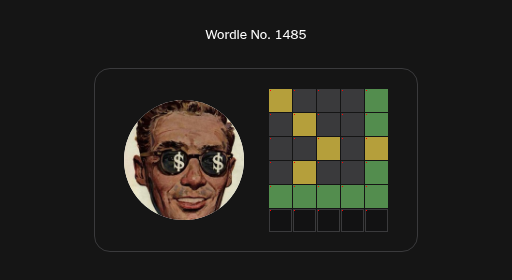

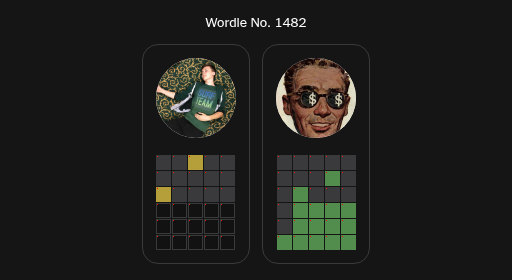

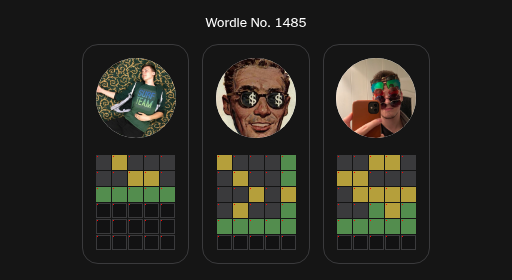

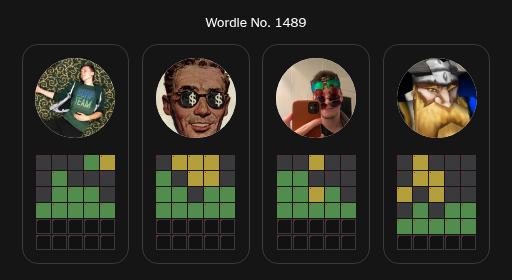

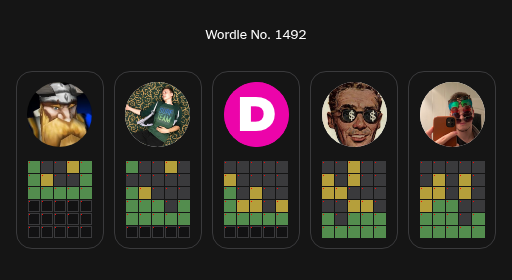

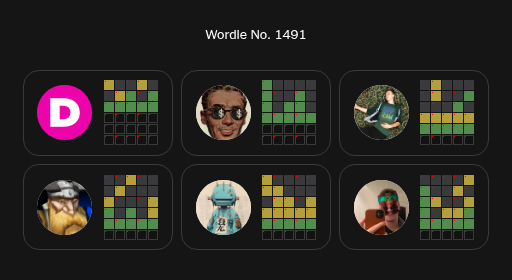

In [44]:


@dataclass
class Layout:
    users: int  # int number of participants
    cell_size_px: Point
    first_cell_positions: list[Point]  # list of all positions of first cells
    intercell_interval_px: int = 1
    matrix_size = (6, 5)  # number of cells in each direction (rows, columns)

    def get_cell_coordinates(self) -> dict[int, list[list[Point]]]:
        """Get dict with key as a user number on the layout, and value as it's matrix coordinates"""
        coordinates = dict()
        for i, position in enumerate(self.first_cell_positions):
            coordinates[i] = [
                [Point(position.r + (self.intercell_interval_px + self.cell_size_px.r) * j,
                       position.c + (self.intercell_interval_px + self.cell_size_px.c) * i) for i in
                 range(self.matrix_size[1])]
                for j in range(self.matrix_size[0])
            ]
        return coordinates


result_grid = {
    1: Layout(
        users=1,
        cell_size_px=Point(23, 23),
        first_cell_positions=[
            Point(90, 270)
        ]
    ),
    2: Layout(
        users=2,
        cell_size_px=Point(15, 15),
        first_cell_positions=[
            Point(156, 157),
            Point(156, 278)
        ]
    ),
    3: Layout(
        users=3,
        cell_size_px=Point(15, 15),
        first_cell_positions=[
            Point(156, 97),
            Point(156, 218),
            Point(156, 338)
        ]
    ),
    4: Layout(
        users=4,
        cell_size_px=Point(15, 15),
        first_cell_positions=[
            Point(156, 37),
            Point(156, 157),
            Point(156, 278),
            Point(156, 398),
        ]
    ),
    5: Layout(
        users=5,
        cell_size_px=Point(12, 12),
        first_cell_positions=[
            Point(162, 29),
            Point(162, 127),
            Point(162, 225),
            Point(162, 323),
            Point(162, 421)
        ]
    ),
    6: Layout(
        users=6,
        cell_size_px=Point(10, 10),
        first_cell_positions=[
            Point(81, 105),
            Point(81, 263),
            Point(81, 421),
            Point(176, 105),
            Point(176, 263),
            Point(176, 421)
        ]
    )
}


def color_red_daily_results(daily_image, users_cnt: int):
    layout = result_grid[users_cnt]
    for cell_coordinates in layout.get_cell_coordinates().values():
        for point in flatten(cell_coordinates):
            update_pixel_color(point, daily_image, red)
    return daily_image


# img path and number of participants
test_files = [
    ("2025-07-13T03:33:14.292000+00:00.png", 1),
    ("2025-07-09T22:11:54.838000+00:00.png", 2),
    ("2025-07-14T03:33:17.903000+00:00.png", 3),
    ("2025-07-17T21:18:17.261000+00:00.png", 4),
    ("2025-07-20T22:48:11.667000+00:00.png", 5),
    ("2025-07-19T22:38:13.788000+00:00.png", 6)
]
for file, users_cnt in test_files:
    daily_image = cv2.imread(f"layout_example_imgs/{file}")
    color_red_daily_results(daily_image, users_cnt)
    cv2.imwrite(f"layout_example_red/{users_cnt}.png", daily_image)
    display(Image(filename=f"layout_example_red/{users_cnt}.png"))



In [45]:
def get_daily_results(daily_image, layout: Layout, output_type: str = "str") -> \
        list[list[str]] | list[list[float]]:
    matrices = []
    for cell_coordinates in layout.get_cell_coordinates().values():
        # using the same matrix as before but now instead of coordinates we will get the cell color
        matrix = get_wordle_matrix(daily_image, cell_coordinates, output_type=output_type)
        matrices.append(matrix)
    return matrices


for file, users_cnt in test_files[-1:]:
    layout = result_grid[users_cnt]
    daily_image = cv2.imread(f"layout_example_imgs/{file}")
    matrices = get_daily_results(daily_image, layout)
    for matrix in matrices:
        print(f"========{users_cnt}========")
        print_matrix(matrix)

========6========
üü®‚¨úÔ∏èÔ∏è‚¨úÔ∏èÔ∏èüü®‚¨úÔ∏èÔ∏è
‚¨úÔ∏èÔ∏èüü®üü©‚¨úÔ∏èÔ∏èüü©
üü©üü©üü©üü©üü©
‚¨õ‚¨õ‚¨õ‚¨õ‚¨õ
‚¨õ‚¨õ‚¨õ‚¨õ‚¨õ
‚¨õ‚¨õ‚¨õ‚¨õ‚¨õ
========6========
üü©‚¨úÔ∏èÔ∏è‚¨úÔ∏èÔ∏è‚¨úÔ∏èÔ∏è‚¨úÔ∏èÔ∏è
üü©‚¨úÔ∏èÔ∏è‚¨úÔ∏èÔ∏èüü©‚¨úÔ∏èÔ∏è
üü©‚¨úÔ∏èÔ∏èüü©üü©‚¨úÔ∏èÔ∏è
üü©üü©üü©üü©üü©
‚¨õ‚¨õ‚¨õ‚¨õ‚¨õ
‚¨õ‚¨õ‚¨õ‚¨õ‚¨õ
========6========
‚¨úÔ∏èÔ∏èüü®‚¨úÔ∏èÔ∏è‚¨úÔ∏èÔ∏è‚¨úÔ∏èÔ∏è
‚¨úÔ∏èÔ∏èüü®‚¨úÔ∏èÔ∏è‚¨úÔ∏èÔ∏èüü©
‚¨úÔ∏èÔ∏è‚¨úÔ∏èÔ∏è‚¨úÔ∏èÔ∏èüü©‚¨úÔ∏èÔ∏è
üü®üü®üü®üü®üü®
üü©üü©üü©üü©üü©
‚¨õ‚¨õ‚¨õ‚¨õ‚¨õ
========6========
‚¨úÔ∏èÔ∏è‚¨úÔ∏èÔ∏èüü®‚¨úÔ∏èÔ∏è‚¨úÔ∏èÔ∏è
‚¨úÔ∏èÔ∏èüü®‚¨úÔ∏èÔ∏è‚¨úÔ∏èÔ∏è‚¨úÔ∏èÔ∏è
üü®‚¨úÔ∏èÔ∏è‚¨úÔ∏èÔ∏è‚¨úÔ∏èÔ∏èüü®
üü©‚¨úÔ∏èÔ∏èüü©‚¨úÔ∏èÔ∏èüü®
üü©üü©üü©üü©üü©
‚¨õ‚¨õ‚¨õ‚¨õ‚¨õ
========6========
üü®‚¨úÔ∏èÔ∏è‚¨úÔ∏èÔ∏è‚¨úÔ∏èÔ∏è‚¨úÔ∏èÔ∏è
üü®üü®‚¨úÔ∏èÔ∏è‚¨úÔ∏èÔ∏è‚¨úÔ∏èÔ∏è
‚¨úÔ∏èÔ∏èüü®üü®‚¨úÔ∏èÔ∏èüü®
üü®üü®üü®üü®üü®
üü©üü©üü©üü©üü©
‚¨õ‚¨õ‚¨õ‚¨õ‚¨õ
========6========
‚¨úÔ∏èÔ∏è‚¨úÔ∏èÔ∏è‚¨úÔ∏èÔ∏è‚¨úÔ∏èÔ∏èüü®
üü©‚¨úÔ∏èÔ∏è‚¨úÔ∏èÔ∏èüü®

# Data Analysis

In [46]:
messages_df = pl.read_json("discord_messages.json")
messages_df.schema

Schema([('author', String),
        ('author_nickname', String),
        ('author_id', Int64),
        ('content', String),
        ('timestamp', String),
        ('images_urls', List(String))])

In [47]:
messages_df.describe()


shape: (9, 7)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ statistic  ‚îÜ author        ‚îÜ author_nickn ‚îÜ author_id ‚îÜ content     ‚îÜ timestamp    ‚îÜ images_urls ‚îÇ
‚îÇ ---        ‚îÜ ---           ‚îÜ ame          ‚îÜ ---       ‚îÜ ---         ‚îÜ ---          ‚îÜ ---         ‚îÇ
‚îÇ str        ‚îÜ str           ‚îÜ ---          ‚îÜ f64       ‚îÜ str         ‚îÜ str          ‚îÜ f64         ‚îÇ
‚îÇ            ‚îÜ               ‚îÜ str          ‚îÜ           ‚îÜ             ‚îÜ              ‚îÜ             ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ count      ‚îÜ 1547          ‚îÜ 1547         ‚îÜ 1547.0    ‚îÜ 1547        ‚îÜ 1547         ‚îÜ 1547.0      ‚îÇ
‚îÇ null_count ‚îÜ 0             ‚îÜ 0            ‚îÜ 0.0       ‚îÜ 0           ‚îÜ 0            ‚îÜ 0.0         ‚îÇ
‚îÇ mean       ‚îÜ null          ‚îÜ null         ‚îÜ 6.0021e17 ‚îÜ null        ‚îÜ null         ‚îÜ null        ‚îÇ
‚îÇ std        ‚îÜ null          ‚îÜ null         ‚îÜ 2.5820e17 ‚îÜ null        ‚îÜ null         ‚îÜ null        ‚îÇ
‚îÇ min        ‚îÜ Chill Party   ‚îÜ Altf4        ‚îÜ 1.2166e17 ‚îÜ             ‚îÜ 2024-02-10T1 ‚îÜ null        ‚îÇ
‚îÇ            ‚îÜ bot           ‚îÜ              ‚îÜ           ‚îÜ             ‚îÜ 0:29:52.1830 ‚îÜ             ‚îÇ
‚îÇ            ‚îÜ               ‚îÜ              ‚îÜ           ‚îÜ             ‚îÜ 00+00:00     ‚îÜ             ‚îÇ
‚îÇ 25%        ‚îÜ null          ‚îÜ null         ‚îÜ 3.9417e17 ‚îÜ null        ‚îÜ null         ‚îÜ null        ‚îÇ
‚îÇ 50%        ‚îÜ null          ‚îÜ null         ‚îÜ 4.6263e17 ‚îÜ null        ‚îÜ null         ‚îÜ null        ‚îÇ
‚îÇ 75%        ‚îÜ null          ‚îÜ null         ‚îÜ 6.6241e17 ‚îÜ null        ‚îÜ null         ‚îÜ null        ‚îÇ
‚îÇ max        ‚îÜ zurg_g        ‚îÜ –ß—É–≥–∞–π—Å—Ç–µ—Ä    ‚îÜ 1.3899e18 ‚îÜ üëÜ—ç—Ç–æ –ü–∞—Ä–∏–∂ ‚îÜ 2025-07-25T2 ‚îÜ null        ‚îÇ
‚îÇ            ‚îÜ               ‚îÜ              ‚îÜ           ‚îÜ             ‚îÜ 2:25:51.0380 ‚îÜ             ‚îÇ
‚îÇ            ‚îÜ               ‚îÜ              ‚îÜ           ‚îÜ             ‚îÜ 00+00:00     ‚îÜ             ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [49]:
wordle_messages = messages_df.filter(pl.col("author_id") == 1211781489931452447).filter(pl.col("content").str.contains("\\*\\*Your group is on a"))
wordle_messages.describe()

shape: (9, 7)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ statistic  ‚îÜ author ‚îÜ author_nicknam ‚îÜ author_id ‚îÜ content        ‚îÜ timestamp      ‚îÜ images_urls ‚îÇ
‚îÇ ---        ‚îÜ ---    ‚îÜ e              ‚îÜ ---       ‚îÜ ---            ‚îÜ ---            ‚îÜ ---         ‚îÇ
‚îÇ str        ‚îÜ str    ‚îÜ ---            ‚îÜ f64       ‚îÜ str            ‚îÜ str            ‚îÜ f64         ‚îÇ
‚îÇ            ‚îÜ        ‚îÜ str            ‚îÜ           ‚îÜ                ‚îÜ                ‚îÜ             ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ count      ‚îÜ 40     ‚îÜ 40             ‚îÜ 40.0      ‚îÜ 40             ‚îÜ 40             ‚îÜ 40.0        ‚îÇ
‚îÇ null_count ‚îÜ 0      ‚îÜ 0              ‚îÜ 0.0       ‚îÜ 0              ‚îÜ 0              ‚îÜ 0.0         ‚îÇ
‚îÇ mean       ‚îÜ null   ‚îÜ null           ‚îÜ 1.2118e18 ‚îÜ null           ‚îÜ null           ‚îÜ null        ‚îÇ
‚îÇ std        ‚îÜ null   ‚îÜ null           ‚îÜ 0.0       ‚îÜ null           ‚îÜ null           ‚îÜ null        ‚îÇ
‚îÇ min        ‚îÜ Wordle ‚îÜ Wordle         ‚îÜ 1.2118e18 ‚îÜ **Your group   ‚îÜ 2025-06-13T22: ‚îÜ null        ‚îÇ
‚îÇ            ‚îÜ        ‚îÜ                ‚îÜ           ‚îÜ is on a 1 day  ‚îÜ 41:03.744000+0 ‚îÜ             ‚îÇ
‚îÇ            ‚îÜ        ‚îÜ                ‚îÜ           ‚îÜ streak!** üî•   ‚îÜ 0:00           ‚îÜ             ‚îÇ
‚îÇ            ‚îÜ        ‚îÜ                ‚îÜ           ‚îÜ Here are       ‚îÜ                ‚îÜ             ‚îÇ
‚îÇ            ‚îÜ        ‚îÜ                ‚îÜ           ‚îÜ yesterday's    ‚îÜ                ‚îÜ             ‚îÇ
‚îÇ            ‚îÜ        ‚îÜ                ‚îÜ           ‚îÜ results:\nüëë   ‚îÜ                ‚îÜ             ‚îÇ
‚îÇ            ‚îÜ        ‚îÜ                ‚îÜ           ‚îÜ 4/6: <@4441856 ‚îÜ                ‚îÜ             ‚îÇ
‚îÇ            ‚îÜ        ‚îÜ                ‚îÜ           ‚îÜ 80474800129>\n ‚îÜ                ‚îÜ             ‚îÇ
‚îÇ            ‚îÜ        ‚îÜ                ‚îÜ           ‚îÜ 6/6: <@3941714 ‚îÜ                ‚îÜ             ‚îÇ
‚îÇ            ‚îÜ        ‚îÜ                ‚îÜ           ‚îÜ 50120208389>   ‚îÜ                ‚îÜ             ‚îÇ
‚îÇ 25%        ‚îÜ null   ‚îÜ null           ‚îÜ 1.2118e18 ‚îÜ null           ‚îÜ null           ‚îÜ null        ‚îÇ
‚îÇ 50%        ‚îÜ null   ‚îÜ null           ‚îÜ 1.2118e18 ‚îÜ null           ‚îÜ null           ‚îÜ null        ‚îÇ
‚îÇ 75%        ‚îÜ null   ‚îÜ null           ‚îÜ 1.2118e18 ‚îÜ null           ‚îÜ null           ‚îÜ null        ‚îÇ
‚îÇ max        ‚îÜ Wordle ‚îÜ Wordle         ‚îÜ 1.2118e18 ‚îÜ **Your group   ‚îÜ 2025-07-25T21: ‚îÜ null        ‚îÇ
‚îÇ            ‚îÜ        ‚îÜ                ‚îÜ           ‚îÜ is on an 8 day ‚îÜ 55:13.103000+0 ‚îÜ             ‚îÇ
‚îÇ            ‚îÜ        ‚îÜ                ‚îÜ           ‚îÜ streak!** üî•   ‚îÜ 0:00           ‚îÜ             ‚îÇ
‚îÇ            ‚îÜ        ‚îÜ                ‚îÜ           ‚îÜ Here are       ‚îÜ                ‚îÜ             ‚îÇ
‚îÇ            ‚îÜ        ‚îÜ                ‚îÜ           ‚îÜ yesterday's    ‚îÜ                ‚îÜ             ‚îÇ
‚îÇ            ‚îÜ        ‚îÜ                ‚îÜ           ‚îÜ results:\nüëë   ‚îÜ                ‚îÜ             ‚îÇ
‚îÇ            ‚îÜ        ‚îÜ                ‚îÜ           ‚îÜ 4/6: <@6624149 ‚îÜ                ‚îÜ             ‚îÇ
‚îÇ            ‚îÜ        ‚îÜ                ‚îÜ           ‚îÜ 28350806044>\n ‚îÜ                ‚îÜ

In [50]:
display(wordle_messages.select("timestamp", "content").sort("timestamp", descending=False).head(10))


shape: (10, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ timestamp                        ‚îÜ content                                                       ‚îÇ
‚îÇ ---                              ‚îÜ ---                                                           ‚îÇ
‚îÇ str                              ‚îÜ str                                                           ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 2025-06-13T22:41:03.744000+00:00 ‚îÜ **Your group is on a 1 day streak!** üî• Here are yesterday's  ‚îÇ
‚îÇ                                  ‚îÜ results:\nüëë 4/6: <@690142381726892042>\nX/6:                 ‚îÇ
‚îÇ                                  ‚îÜ <@444185680474800129>                                         ‚îÇ
‚îÇ 2025-06-16T21:08:12.672000+00:00 ‚îÜ **Your group is on a 1 day streak!** üî• Here are yesterday's  ‚îÇ
‚îÇ                                  ‚îÜ results:\nüëë 5/6: <@394171450120208389>\n6/6:                 ‚îÇ
‚îÇ                                  ‚îÜ <@690142381726892042>                                         ‚îÇ
‚îÇ 2025-06-17T21:09:19.854000+00:00 ‚îÜ **Your group is on a 2 day streak!** üî• Here are yesterday's  ‚îÇ
‚îÇ                                  ‚îÜ results:\nüëë 6/6: <@394171450120208389> <@444185680474800129> ‚îÇ
‚îÇ                                  ‚îÜ <@690142381726892042>                                         ‚îÇ
‚îÇ 2025-06-18T22:15:21.977000+00:00 ‚îÜ **Your group is on a 3 day streak!** üî• Here are yesterday's  ‚îÇ
‚îÇ                                  ‚îÜ results:\nüëë 4/6: <@662414928350806044>                       ‚îÇ
‚îÇ                                  ‚îÜ <@444185680474800129>\n6/6: <@394171450120208389>\nX/6:       ‚îÇ
‚îÇ                                  ‚îÜ <@690142381726892042>                                         ‚îÇ
‚îÇ 2025-06-20T06:25:09.680000+00:00 ‚îÜ **Your group is on a 4 day streak!** üî• Here are yesterday's  ‚îÇ
‚îÇ                                  ‚îÜ results:\nüëë 4/6: @Sashix <@444185680474800129>\n5/6:         ‚îÇ
‚îÇ                                  ‚îÜ <@662414928350806044>                                         ‚îÇ
‚îÇ 2025-06-21T05:25:26.850000+00:00 ‚îÜ **Your group is on a 5 day streak!** üî• Here are yesterday's  ‚îÇ
‚îÇ                                  ‚îÜ results:\nüëë 3/6: <@394171450120208389>                       ‚îÇ
‚îÇ                                  ‚îÜ <@444185680474800129>\n5/6: <@662414928350806044>             ‚îÇ
‚îÇ 2025-06-22T05:39:04.985000+00:00 ‚îÜ **Your group is on a 6 day streak!** üî• Here are yesterday's  ‚îÇ
‚îÇ                                  ‚îÜ results:\nüëë 4/6: <@444185680474800129>\n5/6:                 ‚îÇ
‚îÇ                                  ‚îÜ <@394171450120208389>\n6/6: <@662414928350806044>             ‚îÇ
‚îÇ 2025-06-23T06:16:24.472000+00:00 ‚îÜ **Your group is on a 7 day streak!** üî• Here are yesterday's  ‚îÇ
‚îÇ                                  ‚îÜ results:\nüëë 5/6: <@444185680474800129>\n6/6:                 ‚îÇ
‚îÇ                                  ‚îÜ <@394171450120208389> <@245636855993729025>                   ‚îÇ
‚îÇ 2025-06-25T06:03:06.377000+00:00 ‚îÜ **Your group is on a 1 day streak!** üî• Here are yesterday's  ‚îÇ
‚îÇ                                  ‚îÜ results:\nüëë 4/6: <@444185680474800129>\n6/6:                 ‚îÇ
‚îÇ                                  ‚îÜ <@394171450120208389>                                         ‚îÇ
‚îÇ 2025-06-25T23:12:15.860000

In [51]:
fixed_timestamp = wordle_messages.with_columns(
    timestamp_raw=pl.col("timestamp"),
    timestamp=pl.col("timestamp")
    .str.to_datetime(time_zone="UTC")  # parse string as UTC datetime
    .dt.convert_time_zone("Europe/Kyiv")  # convert to Kyiv time
)

print(fixed_timestamp.schema)
pl.Config.set_fmt_str_lengths(1000)  # optionally widen formatting

display(fixed_timestamp.select("timestamp", "content").sort("timestamp", descending=False).head(20))


Schema({'author': String, 'author_nickname': String, 'author_id': Int64, 'content': String, 'timestamp': Datetime(time_unit='us', time_zone='Europe/Kyiv'), 'images_urls': List(String), 'timestamp_raw': String})


shape: (20, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ timestamp                    ‚îÜ content                                                        ‚îÇ
‚îÇ ---                          ‚îÜ ---                                                            ‚îÇ
‚îÇ datetime[Œºs, Europe/Kyiv]    ‚îÜ str                                                            ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 2025-06-14 01:41:03.744 EEST ‚îÜ **Your group is on a 1 day streak!** üî• Here are yesterday's   ‚îÇ
‚îÇ                              ‚îÜ results:\nüëë 4/6: <@690142381726892042>\nX/6:                  ‚îÇ
‚îÇ                              ‚îÜ <@444185680474800129>                                          ‚îÇ
‚îÇ 2025-06-17 00:08:12.672 EEST ‚îÜ **Your group is on a 1 day streak!** üî• Here are yesterday's   ‚îÇ
‚îÇ                              ‚îÜ results:\nüëë 5/6: <@394171450120208389>\n6/6:                  ‚îÇ
‚îÇ                              ‚îÜ <@690142381726892042>                                          ‚îÇ
‚îÇ 2025-06-18 00:09:19.854 EEST ‚îÜ **Your group is on a 2 day streak!** üî• Here are yesterday's   ‚îÇ
‚îÇ                              ‚îÜ results:\nüëë 6/6: <@394171450120208389> <@444185680474800129>  ‚îÇ
‚îÇ                              ‚îÜ <@690142381726892042>                                          ‚îÇ
‚îÇ 2025-06-19 01:15:21.977 EEST ‚îÜ **Your group is on a 3 day streak!** üî• Here are yesterday's   ‚îÇ
‚îÇ                              ‚îÜ results:\nüëë 4/6: <@662414928350806044>                        ‚îÇ
‚îÇ                              ‚îÜ <@444185680474800129>\n6/6: <@394171450120208389>\nX/6:        ‚îÇ
‚îÇ                              ‚îÜ <@690142381726892042>                                          ‚îÇ
‚îÇ 2025-06-20 09:25:09.680 EEST ‚îÜ **Your group is on a 4 day streak!** üî• Here are yesterday's   ‚îÇ
‚îÇ                              ‚îÜ results:\nüëë 4/6: @Sashix <@444185680474800129>\n5/6:          ‚îÇ
‚îÇ                              ‚îÜ <@662414928350806044>                                          ‚îÇ
‚îÇ 2025-06-21 08:25:26.850 EEST ‚îÜ **Your group is on a 5 day streak!** üî• Here are yesterday's   ‚îÇ
‚îÇ                              ‚îÜ results:\nüëë 3/6: <@394171450120208389>                        ‚îÇ
‚îÇ                              ‚îÜ <@444185680474800129>\n5/6: <@662414928350806044>              ‚îÇ
‚îÇ 2025-06-22 08:39:04.985 EEST ‚îÜ **Your group is on a 6 day streak!** üî• Here are yesterday's   ‚îÇ
‚îÇ                              ‚îÜ results:\nüëë 4/6: <@444185680474800129>\n5/6:                  ‚îÇ
‚îÇ                              ‚îÜ <@394171450120208389>\n6/6: <@662414928350806044>              ‚îÇ
‚îÇ 2025-06-23 09:16:24.472 EEST ‚îÜ **Your group is on a 7 day streak!** üî• Here are yesterday's   ‚îÇ
‚îÇ                              ‚îÜ results:\nüëë 5/6: <@444185680474800129>\n6/6:                  ‚îÇ
‚îÇ                              ‚îÜ <@394171450120208389> <@245636855993729025>                    ‚îÇ
‚îÇ 2025-06-25 09:03:06.377 EEST ‚îÜ **Your group is on a 1 day streak!** üî• Here are yesterday's   ‚îÇ
‚îÇ                              ‚îÜ results:\nüëë 4/6: <@444185680474800129>\n6/6:                  ‚îÇ
‚îÇ                              ‚îÜ <@394171450120208389>                                          ‚îÇ
‚îÇ 2025-06-26 02:12:15.860 EEST ‚îÜ **Your group is on a 2 day streak!** üî• Here are yesterday's   ‚îÇ
‚îÇ                              ‚

In [52]:
# get user id, nickname and name from discord messages
users = (
    messages_df
    .select(
        pl.col("author").alias("user"),
        pl.col("author_nickname").alias("user_nickname"),
        pl.col("author_id").alias("user_id"),
    )
    .unique()
)
display(users)

shape: (46, 3)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ user                     ‚îÜ user_nickname   ‚îÜ user_id             ‚îÇ
‚îÇ ---                      ‚îÜ ---             ‚îÜ ---                 ‚îÇ
‚îÇ str                      ‚îÜ str             ‚îÜ i64                 ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ pyrnaiasalochka_28684    ‚îÜ –ü—ã—Ä–Ω–∞—è —Å–∞–ª–æ—á–∫–∞  ‚îÜ 1128385617508712500 ‚îÇ
‚îÇ cian0835                 ‚îÜ Cian            ‚îÜ 453210991329804288  ‚îÇ
‚îÇ kanych_                  ‚îÜ Kanych          ‚îÜ 284020786547654656  ‚îÇ
‚îÇ rikorlaft                ‚îÜ Rikorlaft       ‚îÜ 506935200077316117  ‚îÇ
‚îÇ tar3an4ik                ‚îÜ Tar3an4ik       ‚îÜ 521082874829471754  ‚îÇ
‚îÇ wentivie                 ‚îÜ went‚Äô           ‚îÜ 610843409774804992  ‚îÇ
‚îÇ sashix1                  ‚îÜ Sashix          ‚îÜ 394171450120208389  ‚îÇ
‚îÇ andiseeyou               ‚îÜ AndiSeeYou      ‚îÜ 1079010665932537897 ‚îÇ
‚îÇ sempej__z_tvoho_pidjizdu ‚îÜ user name       ‚îÜ 465852082755338241  ‚îÇ
‚îÇ purple_nani              ‚îÜ Purple          ‚îÜ 689551460261953694  ‚îÇ
‚îÇ selindex                 ‚îÜ Selindex        ‚îÜ 793960441687572512  ‚îÇ
‚îÇ wlki.                    ‚îÜ Wlki            ‚îÜ 483241953979531275  ‚îÇ
‚îÇ moxx1q                   ‚îÜ moxxiq          ‚îÜ 462625683546308618  ‚îÇ
‚îÇ sauron6778               ‚îÜ Sauron          ‚îÜ 313996472091803648  ‚îÇ
‚îÇ safiyyoo                 ‚îÜ saf             ‚îÜ 690307691104698408  ‚îÇ
‚îÇ relaxed0784              ‚îÜ relaxed0784     ‚îÜ 689421376389644293  ‚îÇ
‚îÇ Chill Party bot          ‚îÜ Chill Party bot ‚îÜ 1389920520111128687 ‚îÇ
‚îÇ matheo678                ‚îÜ matheo678       ‚îÜ 1013098697103511683 ‚îÇ
‚îÇ rychisamo                ‚îÜ Rychisamo       ‚îÜ 1149085246638280734 ‚îÇ
‚îÇ kekes666                 ‚îÜ –î–∂–æ–Ω—ñ –î–æ–¥–µ–ø     ‚îÜ 458722461148512263  ‚îÇ
‚îÇ syferplay                ‚îÜ Syfer           ‚îÜ 183968450643886081  ‚îÇ
‚îÇ younesl7930              ‚îÜ Younes L        ‚îÜ 956365874883858492  ‚îÇ
‚îÇ softpron                 ‚îÜ –ì–∞–ª—è–∂—Ä–∞–∞—Ç—å      ‚îÜ 713465753642205284  ‚îÇ
‚îÇ flaygger                 ‚îÜ flaygger        ‚îÜ 121662068133855234  ‚îÇ
‚îÇ sacoor9943               ‚îÜ Wahnsinn        ‚îÜ 444185680474800129  ‚îÇ
‚îÇ Jockie Music             ‚îÜ Jockie Music    ‚îÜ 411916947773587456  ‚îÇ
‚îÇ sergio2287289            ‚îÜ sergio228       ‚îÜ 585158728668676117  ‚îÇ
‚îÇ ssayat                   ‚îÜ –ü—ã—Ä–Ω–∞—è —Å–∞–ª–æ—á–∫–∞  ‚îÜ 603301712647946266  ‚îÇ
‚îÇ kostian_check            ‚îÜ Kostian_check   ‚îÜ 690142381726892042  ‚îÇ
‚îÇ momigochi                ‚îÜ –ß—É–≥–∞–π—Å—Ç–µ—Ä       ‚îÜ 695370058561486858  ‚îÇ
‚îÇ light_end                ‚îÜ Altf4           ‚îÜ 361563285222326276  ‚îÇ
‚îÇ zakk4390                 ‚îÜ Zak             ‚îÜ 401464176335257621  ‚îÇ
‚îÇ cloudiku                 ‚îÜ cloudiku        ‚îÜ 454178734308851722  ‚îÇ
‚îÇ zaka0401                 ‚îÜ ZAKA            ‚îÜ 245636855993729025  ‚îÇ
‚îÇ flaffi4386               ‚îÜ Flaffi          ‚îÜ 269033320065531904  ‚îÇ
‚îÇ val7123                  ‚îÜ val             ‚îÜ 670344808052817930  ‚îÇ
‚îÇ zero.x0_0                ‚îÜ Zero.0          ‚îÜ 666419598999945235  ‚îÇ
‚îÇ sanechdm                 ‚îÜ SanechDM        ‚îÜ 597069712098197505  ‚îÇ
‚îÇ aakov                    ‚îÜ aakov           ‚îÜ 665277976677711903  ‚îÇ
‚îÇ zurg_g                   ‚îÜ Zurg            ‚îÜ 361513402461585408  ‚îÇ
‚îÇ Roll20                   ‚îÜ Roll20          ‚îÜ 1199271093882589195 ‚îÇ
‚îÇ cyberslav8742            ‚îÜ Cyberslav       ‚îÜ 392617391609348098  ‚îÇ
‚îÇ Wordle                   ‚îÜ Wordle          ‚îÜ 

In [53]:
users.group_by("user_id").len().sort("len", descending=True).head(5)

shape: (5, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ user_id             ‚îÜ len ‚îÇ
‚îÇ ---                 ‚îÜ --- ‚îÇ
‚îÇ i64                 ‚îÜ u32 ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 1013098697103511683 ‚îÜ 1   ‚îÇ
‚îÇ 458722461148512263  ‚îÜ 1   ‚îÇ
‚îÇ 1149085246638280734 ‚îÜ 1   ‚îÇ
‚îÇ 690142381726892042  ‚îÜ 1   ‚îÇ
‚îÇ 462625683546308618  ‚îÜ 1   ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [56]:
# get users score by day and layouts
# "**Your group is on a 26 day streak!** üî• Here are yesterday's results:\nüëë
# 3/6: <@690144562202542209>\n4/6: <@394171450120208389>\n5/6: <@690142381726892042> <@662414928350806044> <@245636855993729025> <@444185680474800129>"

users_score = (
    fixed_timestamp
    .with_columns(
        # get only date part of timestamp. Extract 1 day to get actual competition date, not results message date
        pl.col("timestamp").dt.offset_by("-1d").dt.date().alias("date_only"),
        pl.col("content")
        .str.extract(r"üî• Here are yesterday's results:\\nüëë (.+)")
        .str.split("\\n")
        .alias("results_raw")
    )
    .explode("results_raw")
    .with_columns(results_raw=pl.col("results_raw").str.strip_chars())
    .with_columns(
        score=pl.col("results_raw").str.extract(r"^(\d|X)/6"),
        users=pl.col("results_raw").str.extract_all(r"<@(\d+)>|@(\w+)")
    )
    .explode("users")
    .select(pl.col("users").alias("user"), "score", "timestamp_raw", "date_only")
    .with_columns(
        user_id=pl.col("user").str.extract(r"<@(\d+)>").str.to_integer(),
        user_nickname=pl.col("user").str.extract(r"^@([\w_]+)")
    )
    .join(
        users,
        on="user_nickname",
        how="left"
    )
    .with_columns(
        user_id=pl.coalesce(pl.col("user_id"), pl.col("user_id_right"))
    )
    .select("user_id", "user_nickname", "date_only", "timestamp_raw", pl.col("score").str.to_integer(strict=False))
    .join(
        users,
        on="user_id",
        how="left"
    )
    .select("user_id", pl.col("user_nickname_right").alias("user_nickname"), "date_only", "timestamp_raw", "score")
    .with_columns(pl.int_range(0, pl.len()).over("date_only").alias("user_number"))
    .with_columns(pl.col("user_number").max().over("date_only").alias("users_cnt") + 1)
    .with_columns(img_path=pl.format("imgs/{}.png", pl.col("timestamp_raw")))
)

users_score.head(100)


shape: (100, 8)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ user_id     ‚îÜ user_nickn ‚îÜ date_only  ‚îÜ timestamp_ ‚îÜ score ‚îÜ user_numbe ‚îÜ users_cnt ‚îÜ img_path   ‚îÇ
‚îÇ ---         ‚îÜ ame        ‚îÜ ---        ‚îÜ raw        ‚îÜ ---   ‚îÜ r          ‚îÜ ---       ‚îÜ ---        ‚îÇ
‚îÇ i64         ‚îÜ ---        ‚îÜ date       ‚îÜ ---        ‚îÜ i64   ‚îÜ ---        ‚îÜ i64       ‚îÜ str        ‚îÇ
‚îÇ             ‚îÜ str        ‚îÜ            ‚îÜ str        ‚îÜ       ‚îÜ i64        ‚îÜ           ‚îÜ            ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 69014238172 ‚îÜ Kostian_ch ‚îÜ 2025-07-25 ‚îÜ 2025-07-25 ‚îÜ 5     ‚îÜ 0          ‚îÜ 3         ‚îÜ imgs/2025- ‚îÇ
‚îÇ 6892042     ‚îÜ eck        ‚îÜ            ‚îÜ T21:55:13. ‚îÜ       ‚îÜ            ‚îÜ           ‚îÜ 07-25T21:5 ‚îÇ
‚îÇ             ‚îÜ            ‚îÜ            ‚îÜ 103000+00: ‚îÜ       ‚îÜ            ‚îÜ           ‚îÜ 5:13.10300 ‚îÇ
‚îÇ             ‚îÜ            ‚îÜ            ‚îÜ 00         ‚îÜ       ‚îÜ            ‚îÜ           ‚îÜ 0+00:00.pn ‚îÇ
‚îÇ             ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ       ‚îÜ            ‚îÜ           ‚îÜ g          ‚îÇ
‚îÇ 39417145012 ‚îÜ Sashix     ‚îÜ 2025-07-25 ‚îÜ 2025-07-25 ‚îÜ 5     ‚îÜ 1          ‚îÜ 3         ‚îÜ imgs/2025- ‚îÇ
‚îÇ 0208389     ‚îÜ            ‚îÜ            ‚îÜ T21:55:13. ‚îÜ       ‚îÜ            ‚îÜ           ‚îÜ 07-25T21:5 ‚îÇ
‚îÇ             ‚îÜ            ‚îÜ            ‚îÜ 103000+00: ‚îÜ       ‚îÜ            ‚îÜ           ‚îÜ 5:13.10300 ‚îÇ
‚îÇ             ‚îÜ            ‚îÜ            ‚îÜ 00         ‚îÜ       ‚îÜ            ‚îÜ           ‚îÜ 0+00:00.pn ‚îÇ
‚îÇ             ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ       ‚îÜ            ‚îÜ           ‚îÜ g          ‚îÇ
‚îÇ 44418568047 ‚îÜ Wahnsinn   ‚îÜ 2025-07-25 ‚îÜ 2025-07-25 ‚îÜ 6     ‚îÜ 2          ‚îÜ 3         ‚îÜ imgs/2025- ‚îÇ
‚îÇ 4800129     ‚îÜ            ‚îÜ            ‚îÜ T21:55:13. ‚îÜ       ‚îÜ            ‚îÜ           ‚îÜ 07-25T21:5 ‚îÇ
‚îÇ             ‚îÜ            ‚îÜ            ‚îÜ 103000+00: ‚îÜ       ‚îÜ            ‚îÜ           ‚îÜ 5:13.10300 ‚îÇ
‚îÇ             ‚îÜ            ‚îÜ            ‚îÜ 00         ‚îÜ       ‚îÜ            ‚îÜ           ‚îÜ 0+00:00.pn ‚îÇ
‚îÇ             ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ       ‚îÜ            ‚îÜ           ‚îÜ g          ‚îÇ
‚îÇ 69014238172 ‚îÜ Kostian_ch ‚îÜ 2025-07-24 ‚îÜ 2025-07-24 ‚îÜ 4     ‚îÜ 0          ‚îÜ 5         ‚îÜ imgs/2025- ‚îÇ
‚îÇ 6892042     ‚îÜ eck        ‚îÜ            ‚îÜ T22:28:07. ‚îÜ       ‚îÜ            ‚îÜ           ‚îÜ 07-24T22:2 ‚îÇ
‚îÇ             ‚îÜ            ‚îÜ            ‚îÜ 740000+00: ‚îÜ       ‚îÜ            ‚îÜ           ‚îÜ 8:07.74000 ‚îÇ
‚îÇ             ‚îÜ            ‚îÜ            ‚îÜ 00         ‚îÜ       ‚îÜ            ‚îÜ           ‚îÜ 0+00:00.pn ‚îÇ
‚îÇ             ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ       ‚îÜ            ‚îÜ           ‚îÜ g          ‚îÇ
‚îÇ 39417145012 ‚îÜ Sashix     ‚îÜ 2025-07-24 ‚îÜ 2025-07-24 ‚îÜ 5     ‚îÜ 1          ‚îÜ 5         ‚îÜ imgs/2025- ‚îÇ
‚îÇ 0208389     ‚îÜ            ‚îÜ            ‚îÜ T22:28:07. ‚îÜ       ‚îÜ            ‚îÜ           ‚îÜ 07-24T22:2 ‚îÇ
‚îÇ             ‚îÜ            ‚îÜ            ‚îÜ 740000+00: ‚îÜ       ‚îÜ            ‚îÜ           ‚îÜ 8:07.74000 ‚îÇ
‚îÇ             ‚îÜ            ‚îÜ            ‚îÜ 00         ‚îÜ       ‚îÜ            ‚îÜ           ‚îÜ 0+00:00.pn ‚îÇ
‚îÇ             ‚îÜ            ‚îÜ            ‚îÜ 

In [57]:
users_score.filter(pl.col("date_only") == pl.date(2025, 7, 19))

shape: (6, 8)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ user_id     ‚îÜ user_nickn ‚îÜ date_only  ‚îÜ timestamp_ ‚îÜ score ‚îÜ user_numbe ‚îÜ users_cnt ‚îÜ img_path   ‚îÇ
‚îÇ ---         ‚îÜ ame        ‚îÜ ---        ‚îÜ raw        ‚îÜ ---   ‚îÜ r          ‚îÜ ---       ‚îÜ ---        ‚îÇ
‚îÇ i64         ‚îÜ ---        ‚îÜ date       ‚îÜ ---        ‚îÜ i64   ‚îÜ ---        ‚îÜ i64       ‚îÜ str        ‚îÇ
‚îÇ             ‚îÜ str        ‚îÜ            ‚îÜ str        ‚îÜ       ‚îÜ i64        ‚îÜ           ‚îÜ            ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 69014456220 ‚îÜ DED        ‚îÜ 2025-07-19 ‚îÜ 2025-07-19 ‚îÜ 3     ‚îÜ 0          ‚îÜ 6         ‚îÜ imgs/2025- ‚îÇ
‚îÇ 2542209     ‚îÜ            ‚îÜ            ‚îÜ T22:38:13. ‚îÜ       ‚îÜ            ‚îÜ           ‚îÜ 07-19T22:3 ‚îÇ
‚îÇ             ‚îÜ            ‚îÜ            ‚îÜ 788000+00: ‚îÜ       ‚îÜ            ‚îÜ           ‚îÜ 8:13.78800 ‚îÇ
‚îÇ             ‚îÜ            ‚îÜ            ‚îÜ 00         ‚îÜ       ‚îÜ            ‚îÜ           ‚îÜ 0+00:00.pn ‚îÇ
‚îÇ             ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ       ‚îÜ            ‚îÜ           ‚îÜ g          ‚îÇ
‚îÇ 39417145012 ‚îÜ Sashix     ‚îÜ 2025-07-19 ‚îÜ 2025-07-19 ‚îÜ 4     ‚îÜ 1          ‚îÜ 6         ‚îÜ imgs/2025- ‚îÇ
‚îÇ 0208389     ‚îÜ            ‚îÜ            ‚îÜ T22:38:13. ‚îÜ       ‚îÜ            ‚îÜ           ‚îÜ 07-19T22:3 ‚îÇ
‚îÇ             ‚îÜ            ‚îÜ            ‚îÜ 788000+00: ‚îÜ       ‚îÜ            ‚îÜ           ‚îÜ 8:13.78800 ‚îÇ
‚îÇ             ‚îÜ            ‚îÜ            ‚îÜ 00         ‚îÜ       ‚îÜ            ‚îÜ           ‚îÜ 0+00:00.pn ‚îÇ
‚îÇ             ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ       ‚îÜ            ‚îÜ           ‚îÜ g          ‚îÇ
‚îÇ 69014238172 ‚îÜ Kostian_ch ‚îÜ 2025-07-19 ‚îÜ 2025-07-19 ‚îÜ 5     ‚îÜ 2          ‚îÜ 6         ‚îÜ imgs/2025- ‚îÇ
‚îÇ 6892042     ‚îÜ eck        ‚îÜ            ‚îÜ T22:38:13. ‚îÜ       ‚îÜ            ‚îÜ           ‚îÜ 07-19T22:3 ‚îÇ
‚îÇ             ‚îÜ            ‚îÜ            ‚îÜ 788000+00: ‚îÜ       ‚îÜ            ‚îÜ           ‚îÜ 8:13.78800 ‚îÇ
‚îÇ             ‚îÜ            ‚îÜ            ‚îÜ 00         ‚îÜ       ‚îÜ            ‚îÜ           ‚îÜ 0+00:00.pn ‚îÇ
‚îÇ             ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ       ‚îÜ            ‚îÜ           ‚îÜ g          ‚îÇ
‚îÇ 66241492835 ‚îÜ demaga     ‚îÜ 2025-07-19 ‚îÜ 2025-07-19 ‚îÜ 5     ‚îÜ 3          ‚îÜ 6         ‚îÜ imgs/2025- ‚îÇ
‚îÇ 0806044     ‚îÜ            ‚îÜ            ‚îÜ T22:38:13. ‚îÜ       ‚îÜ            ‚îÜ           ‚îÜ 07-19T22:3 ‚îÇ
‚îÇ             ‚îÜ            ‚îÜ            ‚îÜ 788000+00: ‚îÜ       ‚îÜ            ‚îÜ           ‚îÜ 8:13.78800 ‚îÇ
‚îÇ             ‚îÜ            ‚îÜ            ‚îÜ 00         ‚îÜ       ‚îÜ            ‚îÜ           ‚îÜ 0+00:00.pn ‚îÇ
‚îÇ             ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ       ‚îÜ            ‚îÜ           ‚îÜ g          ‚îÇ
‚îÇ 24563685599 ‚îÜ ZAKA       ‚îÜ 2025-07-19 ‚îÜ 2025-07-19 ‚îÜ 5     ‚îÜ 4          ‚îÜ 6         ‚îÜ imgs/2025- ‚îÇ
‚îÇ 3729025     ‚îÜ            ‚îÜ            ‚îÜ T22:38:13. ‚îÜ       ‚îÜ            ‚îÜ           ‚îÜ 07-19T22:3 ‚îÇ
‚îÇ             ‚îÜ            ‚îÜ            ‚îÜ 788000+00: ‚îÜ       ‚îÜ            ‚îÜ           ‚îÜ 8:13.78800 ‚îÇ
‚îÇ             ‚îÜ            ‚îÜ            ‚îÜ 00         ‚îÜ       ‚îÜ            ‚îÜ           ‚îÜ 0+00:00.pn ‚îÇ
‚îÇ             ‚îÜ            ‚îÜ            ‚îÜ   

In [58]:
def proccess_image(img_path: str, users_cnt: int, user_number: int, output_type: str = "int"):
    layout = result_grid[users_cnt]
    daily_image = cv2.imread(img_path)
    matrix = get_daily_results(daily_image, layout, output_type)[user_number]
    if output_type == "int":
        return np.array(matrix)
    else: 
        return matrix

users_score_test = users_score.with_columns([
    pl.struct(["img_path", "users_cnt", "user_number"]).map_elements(
        lambda row: proccess_image(row["img_path"], row["users_cnt"], row["user_number"], "str")
    ).alias("matrices")
])
print_matrix(users_score_test.select("matrices").head(1).item().to_list())
users_score_test.head(1)


/var/folders/6k/pgkjzwf5565dsnb9yf06xcxm0000gn/T/ipykernel_16243/847798498.py:10: MapWithoutReturnDtypeWarning:

Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.



‚¨úÔ∏èÔ∏èüü®‚¨úÔ∏èÔ∏è‚¨úÔ∏èÔ∏èüü®
üü®üü®‚¨úÔ∏èÔ∏è‚¨úÔ∏èÔ∏è‚¨úÔ∏èÔ∏è
‚¨úÔ∏èÔ∏èüü®üü®‚¨úÔ∏èÔ∏è‚¨úÔ∏èÔ∏è
‚¨úÔ∏èÔ∏èüü©‚¨úÔ∏èÔ∏è‚¨úÔ∏èÔ∏èüü®
üü©üü©üü©üü©üü©
‚¨õ‚¨õ‚¨õ‚¨õ‚¨õ


shape: (1, 9)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ user_id   ‚îÜ user_nick ‚îÜ date_only ‚îÜ timestamp ‚îÜ ‚Ä¶ ‚îÜ user_numb ‚îÜ users_cnt ‚îÜ img_path  ‚îÜ matrices ‚îÇ
‚îÇ ---       ‚îÜ name      ‚îÜ ---       ‚îÜ _raw      ‚îÜ   ‚îÜ er        ‚îÜ ---       ‚îÜ ---       ‚îÜ ---      ‚îÇ
‚îÇ i64       ‚îÜ ---       ‚îÜ date      ‚îÜ ---       ‚îÜ   ‚îÜ ---       ‚îÜ i64       ‚îÜ str       ‚îÜ list[lis ‚îÇ
‚îÇ           ‚îÜ str       ‚îÜ           ‚îÜ str       ‚îÜ   ‚îÜ i64       ‚îÜ           ‚îÜ           ‚îÜ t[str]]  ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 690142381 ‚îÜ Kostian_c ‚îÜ 2025-07-2 ‚îÜ 2025-07-2 ‚îÜ ‚Ä¶ ‚îÜ 0         ‚îÜ 3         ‚îÜ imgs/2025 ‚îÜ [["‚¨úÔ∏èÔ∏è",  ‚îÇ
‚îÇ 726892042 ‚îÜ heck      ‚îÜ 5         ‚îÜ 5T21:55:1 ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ -07-25T21 ‚îÜ "üü®", ‚Ä¶  ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ 3.103000+ ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ :55:13.10 ‚îÜ "üü®"],   ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ 00:00     ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ 3000+00:0 ‚îÜ ["üü®",   ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ 0.png     ‚îÜ "üü®", ‚Ä¶  ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ "‚¨úÔ∏èÔ∏è"], ‚Ä¶ ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ ["‚¨õ",   ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ "‚¨õ", ‚Ä¶  ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ "‚¨õ"]]   ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [59]:
users_score = users_score.with_columns([
    pl.struct(["img_path", "users_cnt", "user_number"]).map_elements(
        lambda row: proccess_image(row["img_path"], row["users_cnt"], row["user_number"], "int")
    ).alias("matrices")
])
print(users_score.select("matrices").head(1).item())


/var/folders/6k/pgkjzwf5565dsnb9yf06xcxm0000gn/T/ipykernel_16243/2462966694.py:1: MapWithoutReturnDtypeWarning:

Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.



[[0.0 0.5 0.0 0.0 0.5]
 [0.5 0.5 0.0 0.0 0.0]
 [0.0 0.5 0.5 0.0 0.0]
 [0.0 1.0 0.0 0.0 0.5]
 [1.0 1.0 1.0 1.0 1.0]
 [None None None None None]]


In [60]:
users_score.head(10)

shape: (10, 9)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ user_id   ‚îÜ user_nick ‚îÜ date_only ‚îÜ timestamp ‚îÜ ‚Ä¶ ‚îÜ user_numb ‚îÜ users_cnt ‚îÜ img_path  ‚îÜ matrices ‚îÇ
‚îÇ ---       ‚îÜ name      ‚îÜ ---       ‚îÜ _raw      ‚îÜ   ‚îÜ er        ‚îÜ ---       ‚îÜ ---       ‚îÜ ---      ‚îÇ
‚îÇ i64       ‚îÜ ---       ‚îÜ date      ‚îÜ ---       ‚îÜ   ‚îÜ ---       ‚îÜ i64       ‚îÜ str       ‚îÜ object   ‚îÇ
‚îÇ           ‚îÜ str       ‚îÜ           ‚îÜ str       ‚îÜ   ‚îÜ i64       ‚îÜ           ‚îÜ           ‚îÜ          ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 690142381 ‚îÜ Kostian_c ‚îÜ 2025-07-2 ‚îÜ 2025-07-2 ‚îÜ ‚Ä¶ ‚îÜ 0         ‚îÜ 3         ‚îÜ imgs/2025 ‚îÜ [[0.0    ‚îÇ
‚îÇ 726892042 ‚îÜ heck      ‚îÜ 5         ‚îÜ 5T21:55:1 ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ -07-25T21 ‚îÜ 0.5 0.0  ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ 3.103000+ ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ :55:13.10 ‚îÜ 0.0 0.5] ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ 00:00     ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ 3000+00:0 ‚îÜ [0.5 0.5 ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ 0.png     ‚îÜ 0.0 0.0  ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ 0.0]     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ [0.0 0.5 ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ 0.5 0.0  ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ 0.0]     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ [0.0 1.0 ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ 0.0 0.0  ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ 0.5]     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ [1.0 1.0 ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ 1.0 1.0  ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ 1.0]     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ [None    ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ None     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ None     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ None     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ None]]   ‚îÇ
‚îÇ 394171450 ‚îÜ Sashix    ‚îÜ 2025-07-2 ‚îÜ 2025-07-2 ‚îÜ ‚Ä¶ ‚îÜ 1         ‚îÜ 3         ‚îÜ imgs/2025 ‚îÜ [[0.5    ‚îÇ
‚îÇ 120208389 ‚îÜ           ‚îÜ 5         ‚îÜ 5T21:55:1 ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ -07-25T21 ‚îÜ 0.5 0.0  ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ 3.103000+ ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ :55:13.10 ‚îÜ 0.0 0.0] ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ 00:00     ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ 3000+00:0 ‚îÜ [0

In [19]:
# import shutil
# import os

# # Step 1: Get unique image paths
# unique_paths = users_score.select("img_path").unique()["img_path"].to_list()

# # Step 2: Define destination folder
# destination_folder = "copied_images"
# os.makedirs(destination_folder, exist_ok=True)

# # Step 3: Copy each image to the new folder
# for path in unique_paths:
#     if os.path.isfile(path):  # make sure the file exists
#         filename = os.path.basename(path)
#         destination_path = os.path.join(destination_folder, filename)
#         shutil.copy2(path, destination_path)

In [61]:
users_score.schema

Schema([('user_id', Int64),
        ('user_nickname', String),
        ('date_only', Date),
        ('timestamp_raw', String),
        ('score', Int64),
        ('user_number', Int64),
        ('users_cnt', Int64),
        ('img_path', String),
        ('matrices', Object)])

# Charts

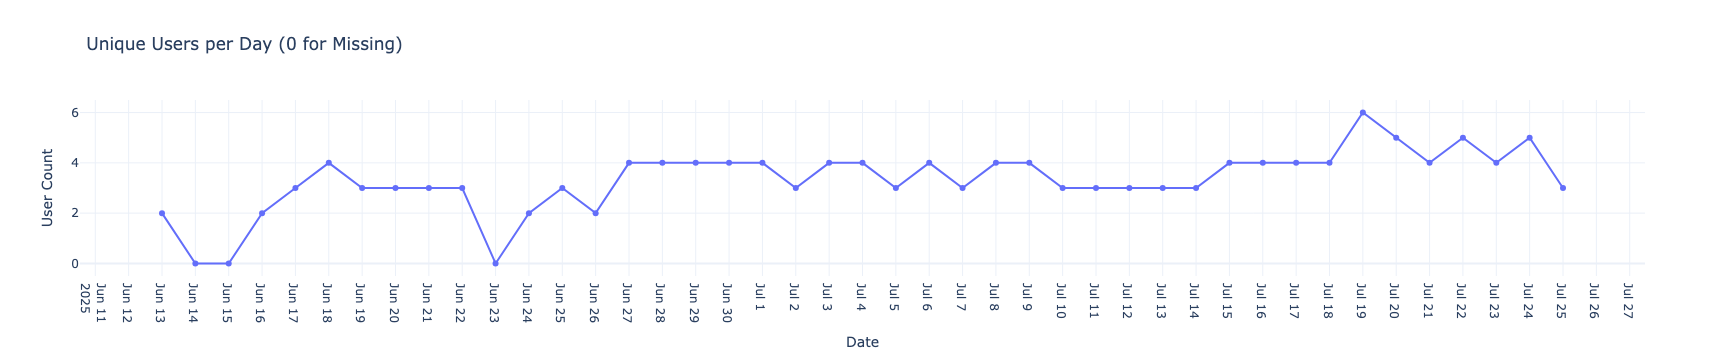

In [62]:
pio.templates.default = "seaborn"  # or "plotly_white", "ggplot2", "seaborn", etc.

# Step 1: Calculate daily users
dedup_df = users_score.unique(subset=["date_only", "user_id"])

daily_users = (
    dedup_df
    .group_by("date_only")
    .agg(pl.len().alias("user_count"))
    .sort("date_only")
)

# Step 2: Generate full date range in Polars
min_date = daily_users["date_only"].min()
max_date = daily_users["date_only"].max()

date_range_df = pl.DataFrame({
    "date_only": pl.date_range(min_date, max_date, interval="1d", eager=True)
})

# Step 3: Left join and fill missing values with 0
filled_users = (
    date_range_df
    .join(daily_users, on="date_only", how="left")
    .fill_null(strategy="zero")
)

# Step 4: Plot using Plotly (no pandas)
fig = go.Figure(
    data=go.Scatter(
        x=filled_users["date_only"].to_list(),
        y=filled_users["user_count"].to_list(),
        mode="lines+markers"
    )
)

fig.update_layout(
    title="Unique Users per Day (0 for Missing)",
    xaxis_title="Date",
    yaxis_title="User Count",
    xaxis=dict(type="date", dtick="D1"),
    template="plotly_white"
)

fig.show()


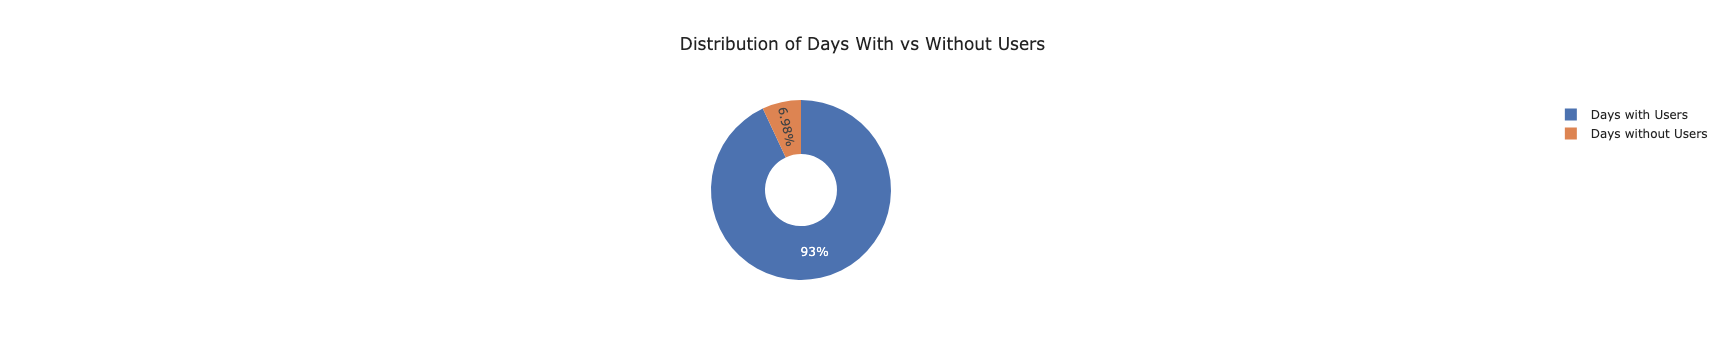

In [63]:
# Step 1: Count days with and without users
with_users = filled_users.filter(pl.col("user_count") > 0).height
without_users = filled_users.filter(pl.col("user_count") == 0).height

# Step 2: Create data for plot
labels = ["Days with Users", "Days without Users"]
values = [with_users, without_users]

# Step 3: Plot pie chart
fig = px.pie(
    names=labels,
    values=values,
    title="Distribution of Days With vs Without Users",
    hole=0.4  # donut style
)

fig.show()


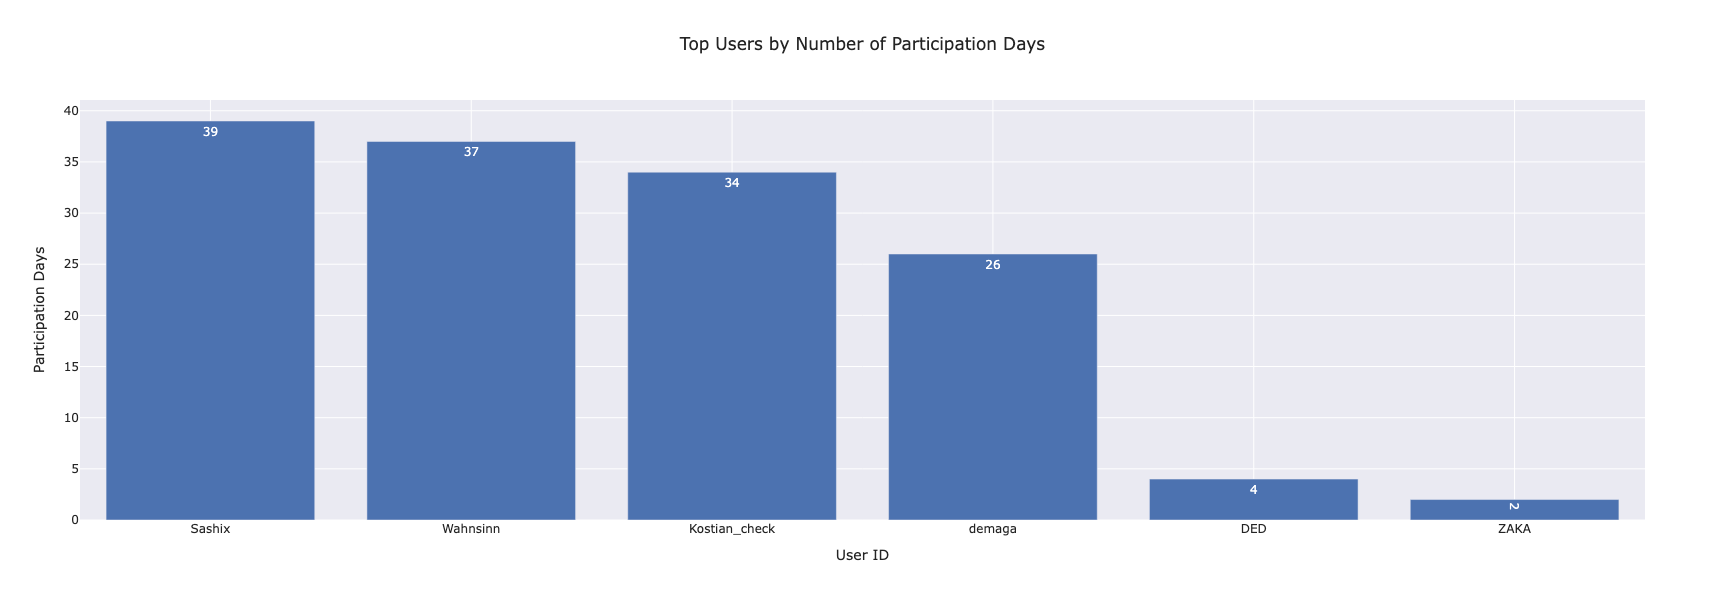

In [81]:
# Step 1: Calculate participation days per user
participation_count = (
    users_score
    .select(["user_nickname", "date_only"])
    .unique()
    .group_by("user_nickname")
    .agg(pl.len().alias("participation_days"))
    .sort("participation_days", descending=True)
    .limit(10)  # top 10 most active users
)

# Step 2: Plot using Plotly
fig = px.bar(
    x=participation_count["user_nickname"].to_list(),
    y=participation_count["participation_days"].to_list(),
    labels={"x": "User ID", "y": "Participation Days"},
    title="Top Users by Number of Participation Days",
    text=participation_count["participation_days"].to_list(),  # ‚Üê values on bars
    text_auto=True,
    height=600
)

fig.show()


In [65]:
# Step 1: All unique dates
all_dates = users_score.select("date_only").unique()

# Step 2: Dates where Sashix participated
sashix_dates = (
    users_score
    .filter(pl.col("user_nickname") == "Sashix")
    .select("date_only")
    .unique()
)

# Step 3: Find date(s) where Sashix did NOT participate
missing_dates = all_dates.join(sashix_dates, on="date_only", how="anti")
display(missing_dates)
users_score.filter(pl.col("date_only") == pl.date(2025, 6, 13))


shape: (1, 1)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ date_only  ‚îÇ
‚îÇ ---        ‚îÇ
‚îÇ date       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 2025-06-13 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

shape: (2, 9)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ user_id   ‚îÜ user_nick ‚îÜ date_only ‚îÜ timestamp ‚îÜ ‚Ä¶ ‚îÜ user_numb ‚îÜ users_cnt ‚îÜ img_path  ‚îÜ matrices ‚îÇ
‚îÇ ---       ‚îÜ name      ‚îÜ ---       ‚îÜ _raw      ‚îÜ   ‚îÜ er        ‚îÜ ---       ‚îÜ ---       ‚îÜ ---      ‚îÇ
‚îÇ i64       ‚îÜ ---       ‚îÜ date      ‚îÜ ---       ‚îÜ   ‚îÜ ---       ‚îÜ i64       ‚îÜ str       ‚îÜ object   ‚îÇ
‚îÇ           ‚îÜ str       ‚îÜ           ‚îÜ str       ‚îÜ   ‚îÜ i64       ‚îÜ           ‚îÜ           ‚îÜ          ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 690142381 ‚îÜ Kostian_c ‚îÜ 2025-06-1 ‚îÜ 2025-06-1 ‚îÜ ‚Ä¶ ‚îÜ 0         ‚îÜ 2         ‚îÜ imgs/2025 ‚îÜ [[0.0    ‚îÇ
‚îÇ 726892042 ‚îÜ heck      ‚îÜ 3         ‚îÜ 3T22:41:0 ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ -06-13T22 ‚îÜ 1.0 0.5  ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ 3.744000+ ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ :41:03.74 ‚îÜ 0.0 0.0] ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ 00:00     ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ 4000+00:0 ‚îÜ [0.0 0.5 ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ 0.png     ‚îÜ 0.0 0.0  ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ 0.0]     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ [1.0 0.0 ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ 0.0 0.5  ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ 0.0]     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ [1.0 1.0 ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ 1.0 1.0  ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ 1.0]     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ [None    ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ None     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ None     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ None     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ None]    ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ [None    ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ None     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ None     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ None     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ None]]   ‚îÇ
‚îÇ 444185680 ‚îÜ Wahnsinn  ‚îÜ 2025-06-1 ‚îÜ 2025-06-1 ‚îÜ ‚Ä¶ ‚îÜ 1         ‚îÜ 2         ‚îÜ imgs/2025 ‚îÜ [[0.  0. ‚îÇ
‚îÇ 474800129 ‚îÜ           ‚îÜ 3         ‚îÜ 3T22:41:0 ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ -06-13T22 ‚îÜ 0. 

In [66]:
users_score.select("user_nickname", "score").describe()

shape: (9, 3)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ statistic  ‚îÜ user_nickname ‚îÜ score    ‚îÇ
‚îÇ ---        ‚îÜ ---           ‚îÜ ---      ‚îÇ
‚îÇ str        ‚îÜ str           ‚îÜ f64      ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ count      ‚îÜ 142           ‚îÜ 124.0    ‚îÇ
‚îÇ null_count ‚îÜ 0             ‚îÜ 18.0     ‚îÇ
‚îÇ mean       ‚îÜ null          ‚îÜ 4.846774 ‚îÇ
‚îÇ std        ‚îÜ null          ‚îÜ 0.979832 ‚îÇ
‚îÇ min        ‚îÜ DED           ‚îÜ 3.0      ‚îÇ
‚îÇ 25%        ‚îÜ null          ‚îÜ 4.0      ‚îÇ
‚îÇ 50%        ‚îÜ null          ‚îÜ 5.0      ‚îÇ
‚îÇ 75%        ‚îÜ null          ‚îÜ 6.0      ‚îÇ
‚îÇ max        ‚îÜ demaga        ‚îÜ 6.0      ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

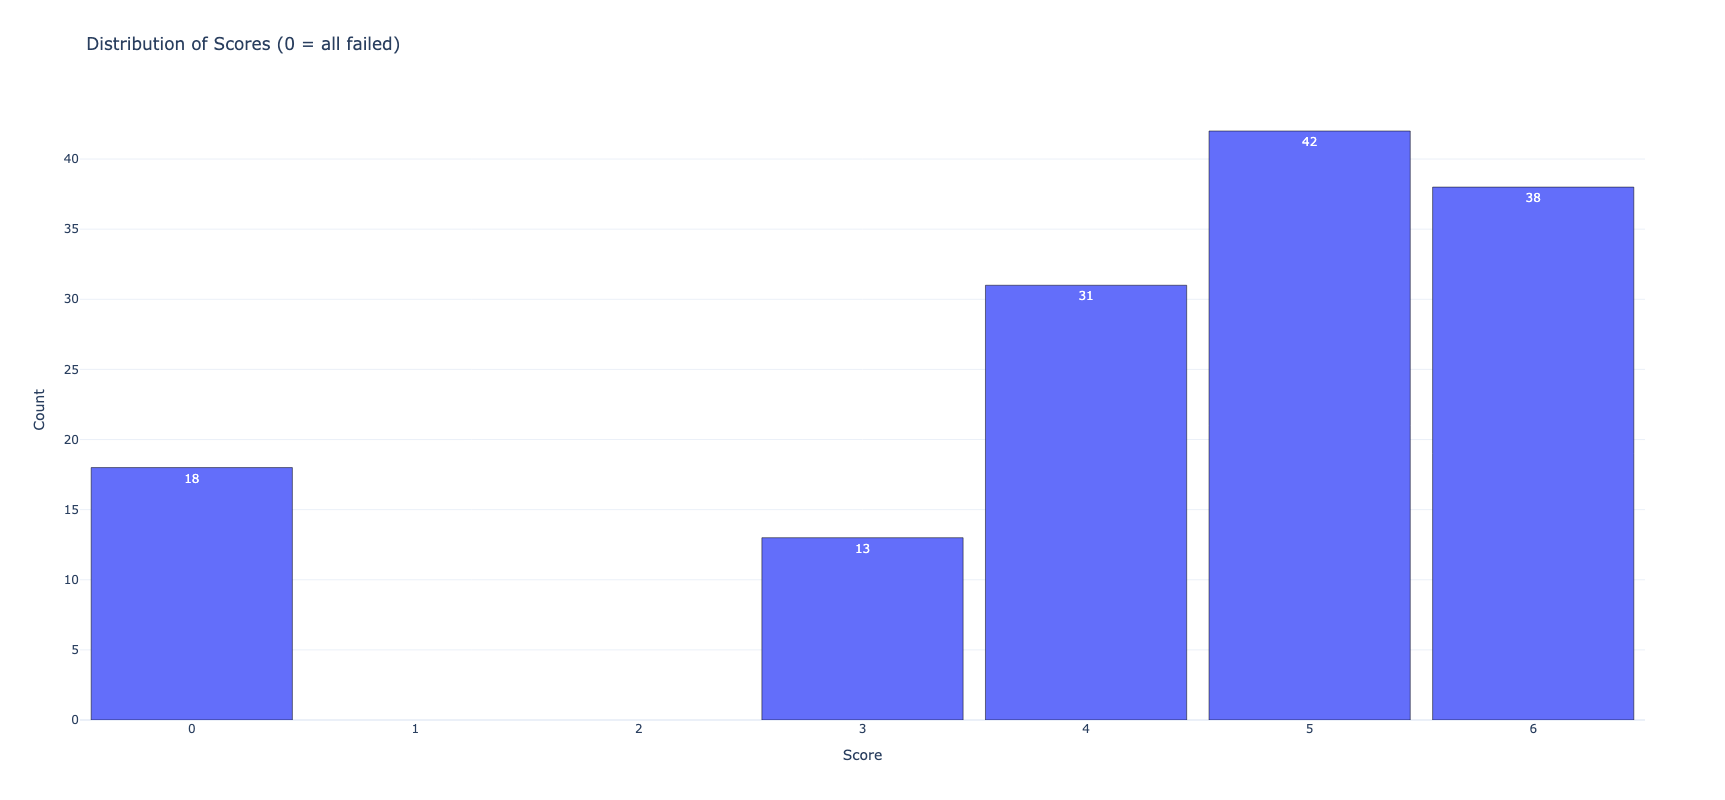

In [85]:
# Step 1: Count how many times each score appears (0‚Äì6)
score_distribution = (
    score_cleaned
    .group_by("score")
    .agg(pl.len().alias("count"))
    .sort("score")
)

# Step 2: Extract for plotting
x_vals = score_distribution["score"].to_list()
y_vals = score_distribution["count"].to_list()

# Step 3: Plot with go.Bar + text labels
fig = go.Figure(data=[
    go.Bar(
        x=x_vals,
        y=y_vals,
        text=y_vals,
        textposition='auto',
        marker=dict(
            line=dict(width=0.5, color='black')
        )
    )
])

fig.update_layout(
    title="Distribution of Scores (0 = all failed)",
    xaxis_title="Score",
    yaxis_title="Count",
    bargap=0.1,
    template="plotly_white",
    height=800
)

fig.show()


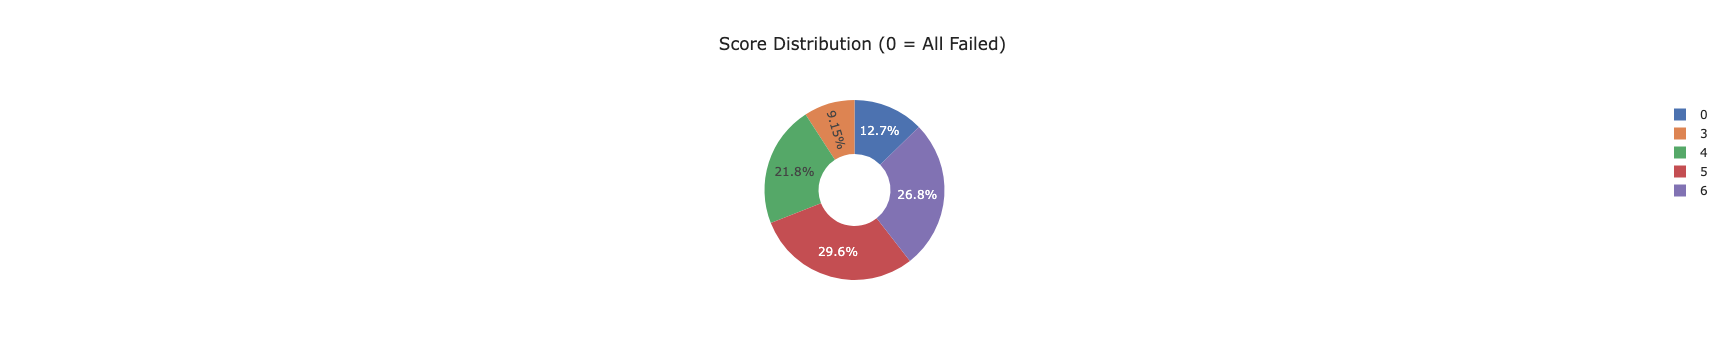

In [68]:
# Group and count by score (from existing score_filled)
score_distribution = (
    score_cleaned
    .group_by("score")
    .agg(pl.len().alias("count"))
    .sort("score")
)

# Extract and sort by score
scores = score_distribution["score"].to_list()
counts = score_distribution["count"].to_list()

# Sort (score, count) by score value
sorted_scores, sorted_counts = zip(*sorted(zip(scores, counts), key=lambda x: x[0]))

# Use graph_objects to plot with preserved order
fig = go.Figure(data=[
    go.Pie(
        labels=sorted_scores,
        values=sorted_counts,
        hole=0.4,
        sort=False  # ‚Üê disables sorting by values
    )
])

fig.update_layout(
    title="Score Distribution (0 = All Failed)"
)

fig.show()



In [69]:
pl.Config.set_tbl_rows(n=100)  # or any large number you expect
score_cleaned.filter(pl.col("score") == 0).select("user_nickname", "date_only")

shape: (18, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ user_nickname ‚îÜ date_only  ‚îÇ
‚îÇ ---           ‚îÜ ---        ‚îÇ
‚îÇ str           ‚îÜ date       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ Wahnsinn      ‚îÜ 2025-07-24 ‚îÇ
‚îÇ Kostian_check ‚îÜ 2025-07-23 ‚îÇ
‚îÇ Kostian_check ‚îÜ 2025-07-21 ‚îÇ
‚îÇ Sashix        ‚îÜ 2025-07-21 ‚îÇ
‚îÇ Kostian_check ‚îÜ 2025-07-16 ‚îÇ
‚îÇ Sashix        ‚îÜ 2025-07-14 ‚îÇ
‚îÇ Kostian_check ‚îÜ 2025-07-12 ‚îÇ
‚îÇ Kostian_check ‚îÜ 2025-07-09 ‚îÇ
‚îÇ Wahnsinn      ‚îÜ 2025-07-04 ‚îÇ
‚îÇ demaga        ‚îÜ 2025-07-03 ‚îÇ
‚îÇ Kostian_check ‚îÜ 2025-07-03 ‚îÇ
‚îÇ Sashix        ‚îÜ 2025-07-02 ‚îÇ
‚îÇ Wahnsinn      ‚îÜ 2025-06-29 ‚îÇ
‚îÇ demaga        ‚îÜ 2025-06-29 ‚îÇ
‚îÇ demaga        ‚îÜ 2025-06-28 ‚îÇ
‚îÇ Sashix        ‚îÜ 2025-06-26 ‚îÇ
‚îÇ Kostian_check ‚îÜ 2025-06-18 ‚îÇ
‚îÇ Wahnsinn      ‚îÜ 2025-06-13 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

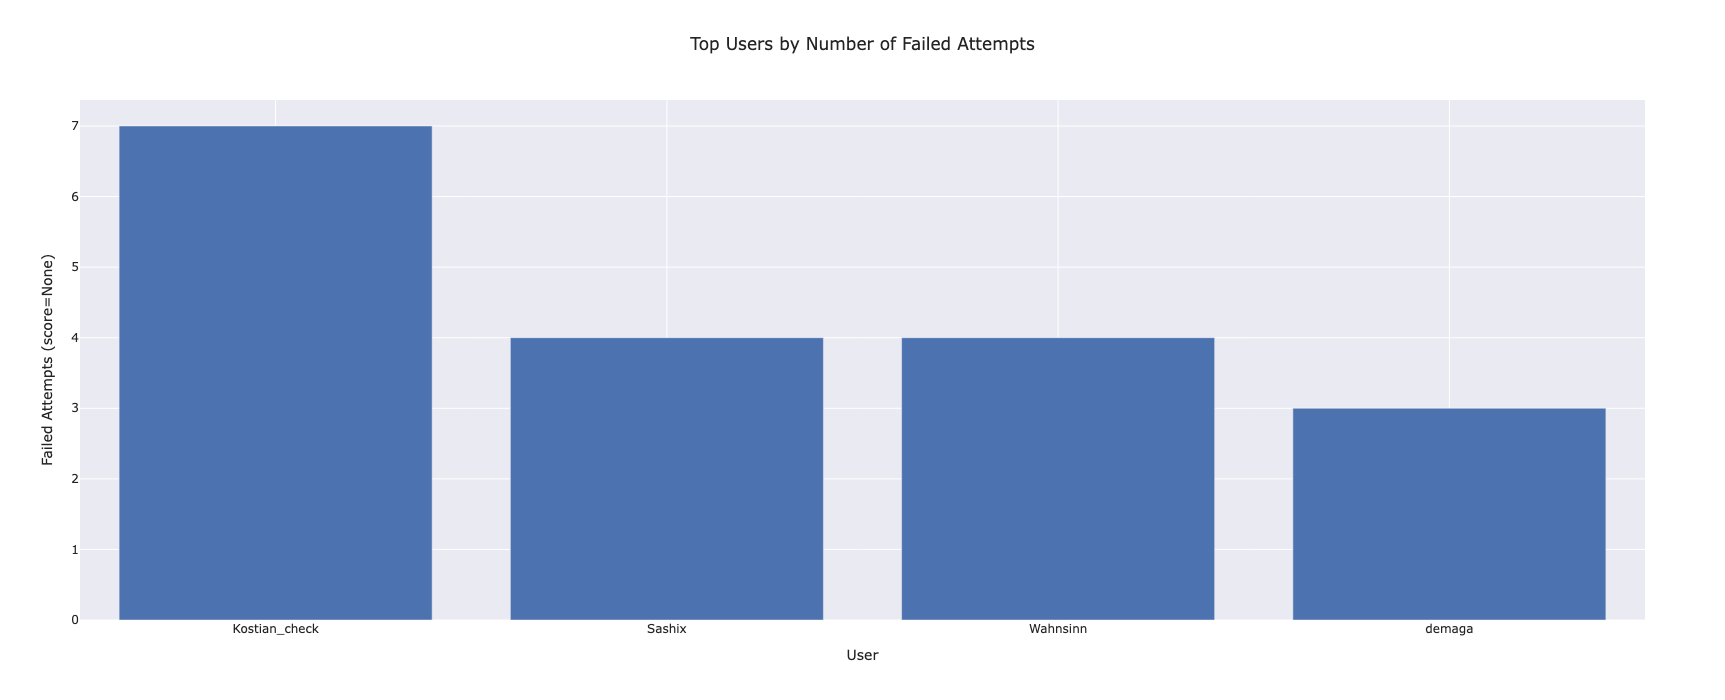

In [88]:
# Step 1‚Äì3: Get top users with most failed attempts
top_failures = (
    users_score
    .filter(pl.col("score").is_null())
    .group_by("user_nickname")
    .agg(pl.len().alias("fail_count"))
    .sort("fail_count", descending=True)
    .limit(10)
)

# Step 4: Plot
fig = px.bar(
    x=top_failures["user_nickname"].to_list(),
    y=top_failures["fail_count"].to_list(),
    labels={"x": "User", "y": "Failed Attempts (score=None)"},
    title="Top Users by Number of Failed Attempts",
    height=700
)

fig.show()

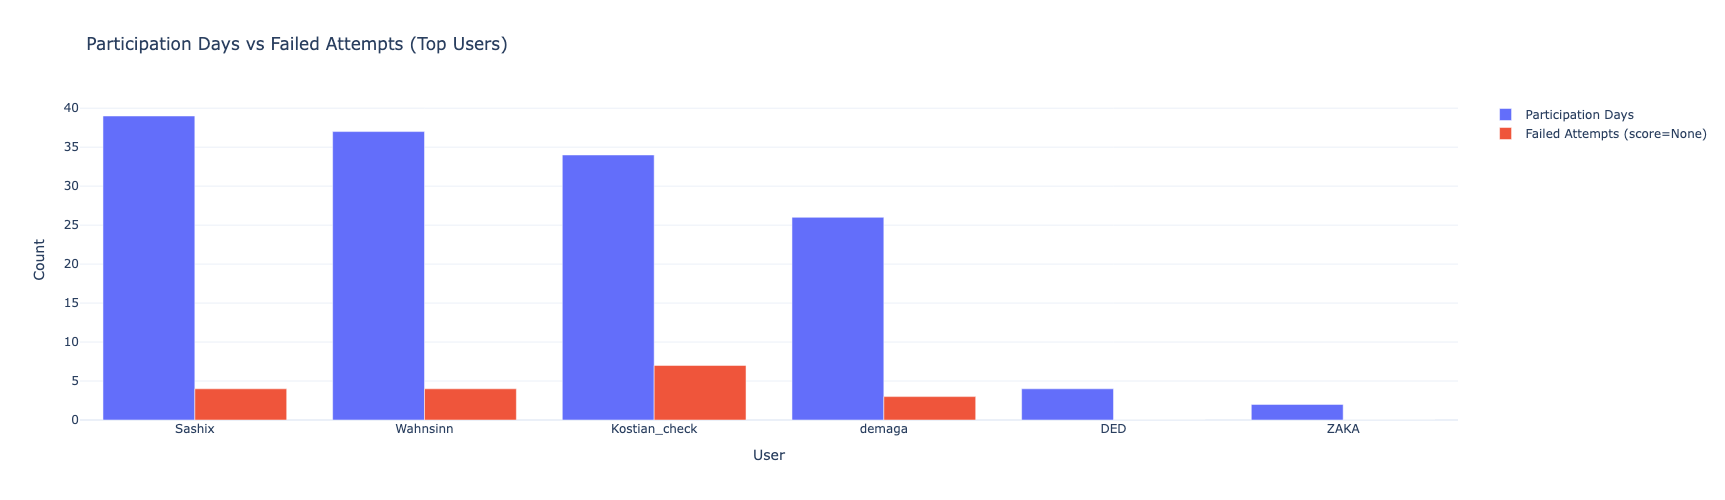

In [71]:
# Step 1: Join the two tables on user_nickname
combined_stats = (
    participation_count
    .join(top_failures, on="user_nickname", how="full")
    .fill_null(0)
    .sort("participation_days", descending=True)
)

# Step 2: Plot grouped bar chart
fig = go.Figure(data=[
    go.Bar(
        name="Participation Days",
        x=combined_stats["user_nickname"].to_list(),
        y=combined_stats["participation_days"].to_list()
    ),
    go.Bar(
        name="Failed Attempts (score=None)",
        x=combined_stats["user_nickname"].to_list(),
        y=combined_stats["fail_count"].to_list(),
    )
])

fig.update_layout(
    barmode="group",
    title="Participation Days vs Failed Attempts (Top Users)",
    xaxis_title="User",
    yaxis_title="Count",
    template="plotly_white",
    height=500
)

fig.show()


In [72]:
# best score
users_score.filter(pl.col("score").is_not_null()).sort("score", descending=False).select("user_nickname", "date_only", "score").head(20)

shape: (20, 3)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ user_nickname ‚îÜ date_only  ‚îÜ score ‚îÇ
‚îÇ ---           ‚îÜ ---        ‚îÜ ---   ‚îÇ
‚îÇ str           ‚îÜ date       ‚îÜ i64   ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ demaga        ‚îÜ 2025-07-20 ‚îÜ 3     ‚îÇ
‚îÇ DED           ‚îÜ 2025-07-19 ‚îÜ 3     ‚îÇ
‚îÇ Wahnsinn      ‚îÜ 2025-07-18 ‚îÜ 3     ‚îÇ
‚îÇ Kostian_check ‚îÜ 2025-07-13 ‚îÜ 3     ‚îÇ
‚îÇ Kostian_check ‚îÜ 2025-07-11 ‚îÜ 3     ‚îÇ
‚îÇ Kostian_check ‚îÜ 2025-07-08 ‚îÜ 3     ‚îÇ
‚îÇ demaga        ‚îÜ 2025-06-30 ‚îÜ 3     ‚îÇ
‚îÇ Kostian_check ‚îÜ 2025-06-28 ‚îÜ 3     ‚îÇ
‚îÇ Sashix        ‚îÜ 2025-06-28 ‚îÜ 3     ‚îÇ
‚îÇ Kostian_check ‚îÜ 2025-06-27 ‚îÜ 3     ‚îÇ
‚îÇ demaga        ‚îÜ 2025-06-27 ‚îÜ 3     ‚îÇ
‚îÇ Sashix        ‚îÜ 2025-06-20 ‚îÜ 3     ‚îÇ
‚îÇ Wahnsinn      ‚îÜ 2025-06-20 ‚îÜ 3     ‚îÇ
‚îÇ Kostian_check ‚îÜ 2025-07-24 ‚îÜ 4     ‚îÇ
‚îÇ demaga        ‚îÜ 2025-07-23 ‚îÜ 4     ‚îÇ
‚îÇ Wahnsinn      ‚îÜ 2025-07-22 ‚îÜ 4     ‚îÇ
‚îÇ Sashix        ‚îÜ 2025-07-19 ‚îÜ 4     ‚îÇ
‚îÇ Kostian_check ‚îÜ 2025-07-18 ‚îÜ 4     ‚îÇ
‚îÇ Sashix        ‚îÜ 2025-07-18 ‚îÜ 4     ‚îÇ
‚îÇ Kostian_check ‚îÜ 2025-07-17 ‚îÜ 4     ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

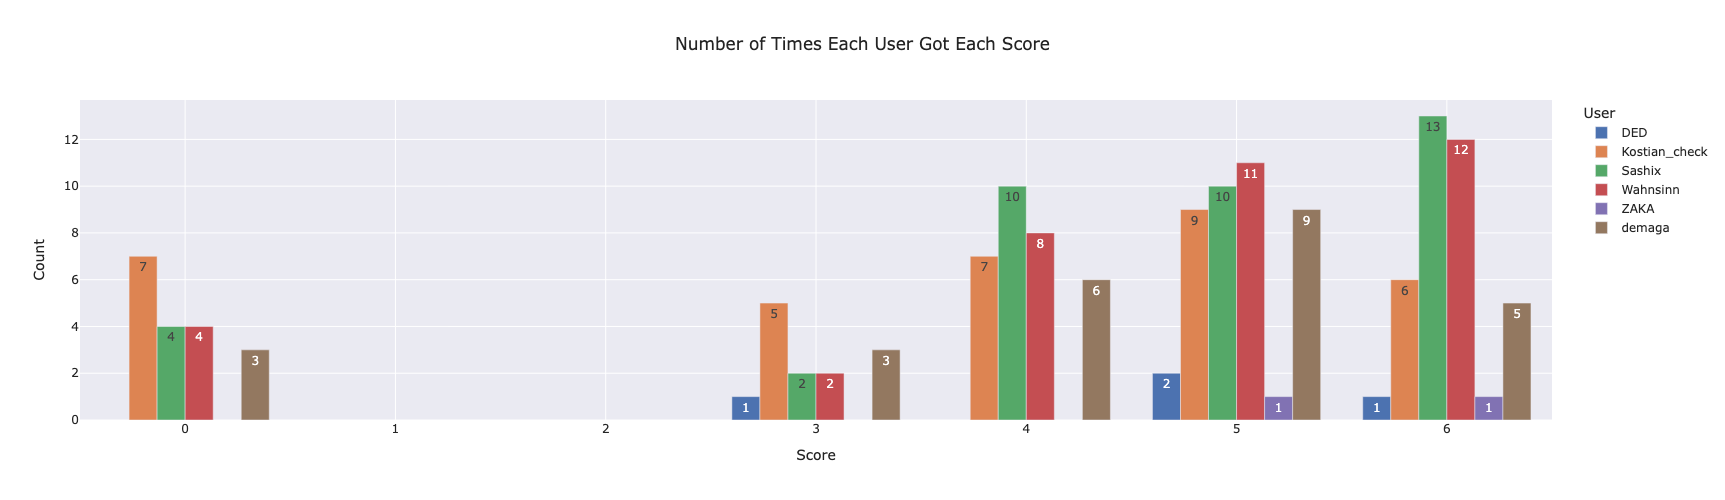

In [89]:
# Step 1: Fill nulls as 0
score_by_user = users_score.with_columns(
    pl.col("score").fill_null(0)
)

# Step 2: Group by user and score, count
score_counts = (
    score_by_user
    .group_by(["user_nickname", "score"])
    .agg(pl.len().alias("count"))
    .sort(["user_nickname", "score"])
)
fig = px.bar(
    score_counts,
    x="score",
    y="count",
    color="user_nickname",
    barmode="group",  # or 'stack' if you prefer
    title="Number of Times Each User Got Each Score",
    labels={"score": "Score", "count": "Count", "user_nickname": "User"},
    text="count",             # ‚Üê show values on bars
    text_auto=True,           # ‚Üê enable automatic formatting and placement
    height=500
)

fig.show()





In [74]:
score_stats_by_user = (
    users_score
    .filter(pl.col("score").is_not_null())
    .group_by("user_nickname")
    .agg([
        pl.col("score").len().alias("count"),
        pl.col("score").mean().alias("mean_score"),
        pl.col("score").median().alias("median_score"),
        pl.col("score").min().alias("min_score"),
        pl.col("score").max().alias("max_score"),
        pl.len().alias("num_games")
    ])
    .sort("mean_score", descending=True)
)
score_stats_by_user


shape: (6, 7)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ user_nickname ‚îÜ count ‚îÜ mean_score ‚îÜ median_score ‚îÜ min_score ‚îÜ max_score ‚îÜ num_games ‚îÇ
‚îÇ ---           ‚îÜ ---   ‚îÜ ---        ‚îÜ ---          ‚îÜ ---       ‚îÜ ---       ‚îÜ ---       ‚îÇ
‚îÇ str           ‚îÜ u32   ‚îÜ f64        ‚îÜ f64          ‚îÜ i64       ‚îÜ i64       ‚îÜ u32       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ ZAKA          ‚îÜ 2     ‚îÜ 5.5        ‚îÜ 5.5          ‚îÜ 5         ‚îÜ 6         ‚îÜ 2         ‚îÇ
‚îÇ Wahnsinn      ‚îÜ 33    ‚îÜ 5.0        ‚îÜ 5.0          ‚îÜ 3         ‚îÜ 6         ‚îÜ 33        ‚îÇ
‚îÇ Sashix        ‚îÜ 35    ‚îÜ 4.971429   ‚îÜ 5.0          ‚îÜ 3         ‚îÜ 6         ‚îÜ 35        ‚îÇ
‚îÇ DED           ‚îÜ 4     ‚îÜ 4.75       ‚îÜ 5.0          ‚îÜ 3         ‚îÜ 6         ‚îÜ 4         ‚îÇ
‚îÇ demaga        ‚îÜ 23    ‚îÜ 4.695652   ‚îÜ 5.0          ‚îÜ 3         ‚îÜ 6         ‚îÜ 23        ‚îÇ
‚îÇ Kostian_check ‚îÜ 27    ‚îÜ 4.592593   ‚îÜ 5.0          ‚îÜ 3         ‚îÜ 6         ‚îÜ 27        ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

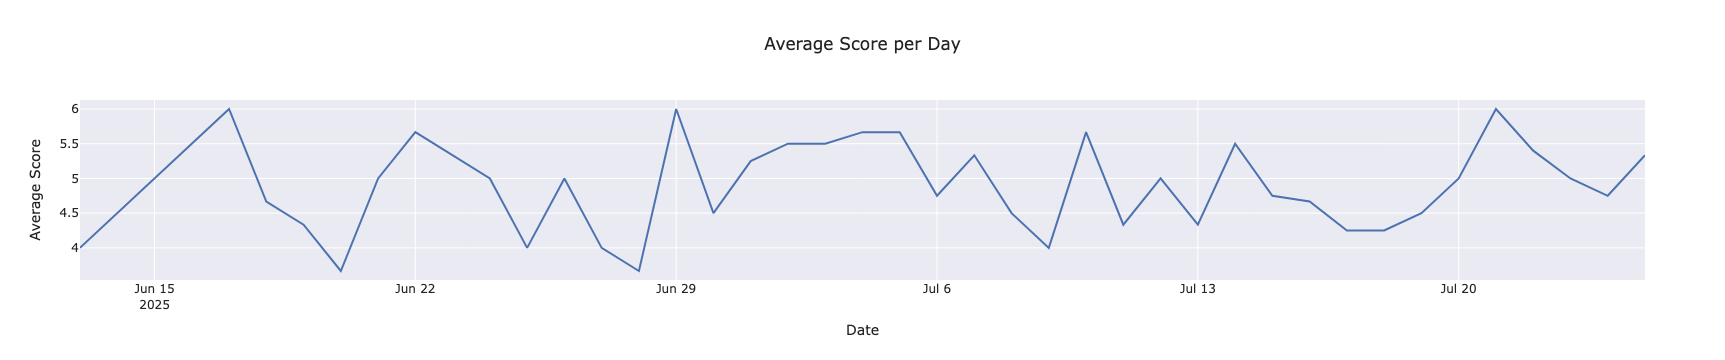

In [90]:
# Step 2: Average score per day
avg_score_per_day = (
    users_score.filter(pl.col("score").is_not_null())
    .group_by("date_only")
    .agg(pl.col("score").mean().alias("avg_score"))
    .sort("date_only")
)

# Step 3: Plot line chart
fig = px.line(
    x=avg_score_per_day["date_only"].to_list(),
    y=avg_score_per_day["avg_score"].to_list(),
    title="Average Score per Day",
    labels={"x": "Date", "y": "Average Score"}
)

fig.show()


# Matrices Charts

In [35]:
# users_score.select("matrices", "user_nickname", "date_only")

In [36]:
# def proccess_image(img_path: str, user_number: int, output_type: str = "int"):
#     for users_cnt, layout in result_grid.items():
#         print(f"{users_cnt=}")
#         print(f"{user_number=}")
#         print(layout)
#         daily_image = cv2.imread(img_path)
#         matrix = get_daily_results(daily_image, layout, output_type)[user_number-1]
#         matrix = np.array(matrix)
#         contains_none = np.any(matrix == -1000000.0)
#         if not contains_none:
#             return matrix


# users_score_test = users_score.filter(pl.col("date_only") == pl.date(2025, 6, 18)) \
#     .with_columns([
#     pl.struct(["img_path", "users_cnt", "user_number"]).map_elements(
#         lambda row: proccess_image(row["img_path"], row["users_cnt"], row["user_number"])
#     ).alias("matrices")
# ])
# print_matrix(users_score_test.select("matrices").head(1).item())
# users_score_test

In [76]:
users_score_with_matrices = users_score.with_columns([
    pl.struct(["img_path", "users_cnt", "user_number"]).map_elements(
        lambda row: proccess_image(row["img_path"], row["users_cnt"], row["user_number"])
    ).alias("matrices")
])
users_score_with_matrices.select("matrices", "user_nickname", "date_only").filter(pl.col("date_only") != pl.date(2025, 6, 18)).head(100)

/var/folders/6k/pgkjzwf5565dsnb9yf06xcxm0000gn/T/ipykernel_16243/3999467834.py:1: MapWithoutReturnDtypeWarning:

Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.



shape: (100, 3)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ matrices                                             ‚îÜ user_nickname ‚îÜ date_only  ‚îÇ
‚îÇ ---                                                  ‚îÜ ---           ‚îÜ ---        ‚îÇ
‚îÇ object                                               ‚îÜ str           ‚îÜ date       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ [[0.0 0.5 0.0 0.0 0.5]                               ‚îÜ Kostian_check ‚îÜ 2025-07-25 ‚îÇ
‚îÇ  [0.5 0.5 0.0 0.0 0.0]                               ‚îÜ               ‚îÜ            ‚îÇ
‚îÇ  [0.0 0.5 0.5 0.0 0.0]                               ‚îÜ               ‚îÜ            ‚îÇ
‚îÇ  [0.0 1.0 0.0 0.0 0.5]                               ‚îÜ               ‚îÜ            ‚îÇ
‚îÇ  [1.0 1.0 1.0 1.0 1.0]                               ‚îÜ               ‚îÜ            ‚îÇ
‚îÇ  [None None None None None]]                         ‚îÜ               ‚îÜ            ‚îÇ
‚îÇ [[0.5 0.5 0.0 0.0 0.0]                               ‚îÜ Sashix        ‚îÜ 2025-07-25 ‚îÇ
‚îÇ  [0.0 1.0 0.5 1.0 0.0]                               ‚îÜ               ‚îÜ            ‚îÇ
‚îÇ  [1.0 1.0 0.0 1.0 1.0]                               ‚îÜ               ‚îÜ            ‚îÇ
‚îÇ  [1.0 1.0 0.0 1.0 1.0]                               ‚îÜ               ‚îÜ            ‚îÇ
‚îÇ  [1.0 1.0 1.0 1.0 1.0]                               ‚îÜ               ‚îÜ            ‚îÇ
‚îÇ  [None None None None None]]                         ‚îÜ               ‚îÜ            ‚îÇ
‚îÇ [[0. 0. 0. 1. 0.]                                    ‚îÜ Wahnsinn      ‚îÜ 2025-07-25 ‚îÇ
‚îÇ  [0. 0. 0. 1. 1.]                                    ‚îÜ               ‚îÜ            ‚îÇ
‚îÇ  [0. 0. 0. 1. 1.]                                    ‚îÜ               ‚îÜ            ‚îÇ
‚îÇ  [0. 0. 0. 1. 1.]                                    ‚îÜ               ‚îÜ            ‚îÇ
‚îÇ  [0. 1. 0. 1. 1.]                                    ‚îÜ               ‚îÜ            ‚îÇ
‚îÇ  [1. 1. 1. 1. 1.]]                                   ‚îÜ               ‚îÜ            ‚îÇ
‚îÇ [[0.0 0.0 1.0 0.0 0.0]                               ‚îÜ Kostian_check ‚îÜ 2025-07-24 ‚îÇ
‚îÇ  [0.0 0.0 0.5 0.0 0.0]                               ‚îÜ               ‚îÜ            ‚îÇ
‚îÇ  [0.5 0.0 1.0 0.0 1.0]                               ‚îÜ               ‚îÜ            ‚îÇ
‚îÇ  [1.0 1.0 1.0 1.0 1.0]                               ‚îÜ               ‚îÜ            ‚îÇ
‚îÇ  [None None None None None]                          ‚îÜ               ‚îÜ            ‚îÇ
‚îÇ  [None None None None None]]                         ‚îÜ               ‚îÜ            ‚îÇ
‚îÇ [[0.0 0.0 0.0 0.0 0.0]                               ‚îÜ Sashix        ‚îÜ 2025-07-24 ‚îÇ
‚îÇ  [0.0 0.0 1.0 0.0 0.0]                               ‚îÜ               ‚îÜ            ‚îÇ
‚îÇ  [0.0 0.5 1.0 0.0 0.0]                               ‚îÜ               ‚îÜ            ‚îÇ
‚îÇ  [0.0 0.0 1.0 0.0 1.0]                               ‚îÜ               ‚îÜ            ‚îÇ
‚îÇ  [1.0 1.0 1.0 1.0 1.0]                               ‚îÜ               ‚îÜ            ‚îÇ
‚îÇ  [None None None None None]]                         ‚îÜ               ‚îÜ            ‚îÇ
‚îÇ [[0.0 0.0 0.0 0.0 0.0]                               ‚îÜ DED           ‚îÜ 2025-07-24 ‚îÇ
‚îÇ  [0.0 1.0 0.0 0.0 0.0]                               ‚îÜ               ‚îÜ            ‚îÇ
‚îÇ  [0.0 1.0 0.5 0.5 0.0]                               ‚îÜ               ‚îÜ            ‚îÇ
‚îÇ  [0.0 0.5 0.0 0.0 1.0]                               ‚îÜ               ‚îÜ          

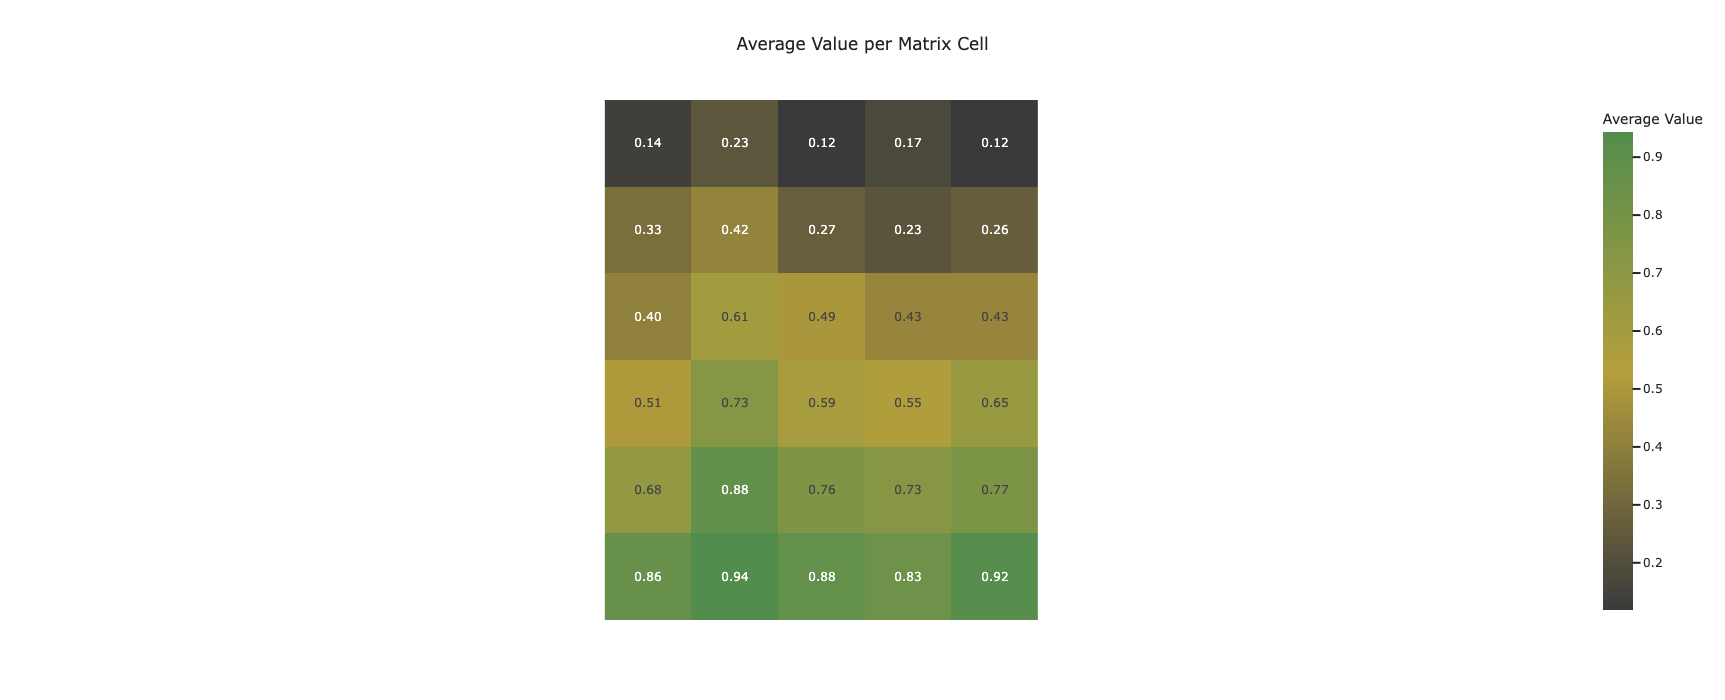

In [104]:
# Extract all matrices as a list of 2D arrays
all_matrices = users_score.filter(pl.col("date_only") != pl.date(2025, 6, 18)).filter(pl.col("date_only") != pl.date(2025, 7, 12))["matrices"].to_list()

# Convert to a 3D numpy array (num_matrices, 6, 5), with np.nan for None
matrix_stack = np.array([
    [[cell if cell is not None else np.nan for cell in row] for row in matrix]
    for matrix in all_matrices
])
# Average over axis 0 (the matrix "samples")
mean_matrix = np.nanmean(matrix_stack, axis=0)

fig = px.imshow(
    mean_matrix,
    labels=dict(color="Average Value"),
    title="Average Value per Matrix Cell",
    text_auto=".2f",  # show values inside cells
    aspect="auto",
    color_continuous_scale= ["#3a3a3c", "#b59f3b", "#538d4e"],
    height=700
)

fig.update_layout(
    xaxis=dict(
        showgrid=False,
        zeroline=False,
        showticklabels=False,
        showline=False
    ),
    yaxis=dict(
        showgrid=False,
        zeroline=False,
        showticklabels=False,
        showline=False,
        scaleanchor="x",  # still keep square cells
        scaleratio=1
    ),
    plot_bgcolor='white',
    paper_bgcolor='white'
)

fig.show()

In [78]:
import numpy as np

emoji_map = {
    1.0 : "üü©",
    0.5: "üü®",
    0.0: "‚¨úÔ∏è",
    None: "‚¨õ",
    np.nan: "‚¨õ"
}
    
# Step 1: Clean matrix (replace None with np.nan)
def to_clean_matrix(matrix):
    return np.array([
        [cell if cell is not None else np.nan for cell in row]
        for row in matrix
    ], dtype=float)

# Step 2: Prepare all cleaned matrices
matrices = [to_clean_matrix(m) for m in all_matrices]
n = len(matrices)

# Step 3: Similarity function
def matrix_similarity(a, b, tolerance=0.01):
    mask = ~np.isnan(a) & ~np.isnan(b)
    total = np.sum(mask)
    
    # Match if values are equal or one is 1 and the other is 0.5
    match_mask = (
        (np.abs(a - b) < tolerance) |  # exact match (e.g. 1 == 1, 0.5 == 0.5, 0 == 0)
        ((a == 1) & (b == 0.5)) |
        ((a == 0.5) & (b == 1))
    )
    
    matches = np.sum(match_mask & mask)
    return matches / total if total > 0 else 0

# Step 4: Compute similarity matrix (n x n)
similarity_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(i + 1, n):
        sim = matrix_similarity(matrices[i], matrices[j])
        similarity_matrix[i, j] = sim
        similarity_matrix[j, i] = sim  # symmetry

# Step 5: Find closest pair
max_sim = -1
best_pairs = []

for i in range(n):
    for j in range(i + 1, n):
        if i != j and similarity_matrix[i, j] > 0.9:
            max_sim = similarity_matrix[i, j]
            best_pairs.append((i, j))

# users_score[best_pair[0]]

fixed_useers_score = users_score.filter(pl.col("date_only") != pl.date(2025, 6, 18)).filter(pl.col("date_only") != pl.date(2025, 7, 12))

for best_pair in best_pairs[:3]:
    display(fixed_useers_score[best_pair[0]])
    display(fixed_useers_score[best_pair[1]])
    print(f"‚úÖ Closest matrices are #{best_pair[0]} and #{best_pair[1]} with similarity {max_sim:.2f}")
    print("Matrix A:")
    for row in matrices[best_pair[0]]:
        for el in row:
            print(emoji_map.get(el, "‚¨õÔ∏è"), end="")
        print("")
    print("Matrix B:")
    for row in matrices[best_pair[1]]:
        for el in row:
            print(emoji_map.get(el, "‚¨õÔ∏è"), end="")
        print("")
    print("=" * 10)



shape: (1, 9)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ user_id   ‚îÜ user_nick ‚îÜ date_only ‚îÜ timestamp ‚îÜ ‚Ä¶ ‚îÜ user_numb ‚îÜ users_cnt ‚îÜ img_path  ‚îÜ matrices ‚îÇ
‚îÇ ---       ‚îÜ name      ‚îÜ ---       ‚îÜ _raw      ‚îÜ   ‚îÜ er        ‚îÜ ---       ‚îÜ ---       ‚îÜ ---      ‚îÇ
‚îÇ i64       ‚îÜ ---       ‚îÜ date      ‚îÜ ---       ‚îÜ   ‚îÜ ---       ‚îÜ i64       ‚îÜ str       ‚îÜ object   ‚îÇ
‚îÇ           ‚îÜ str       ‚îÜ           ‚îÜ str       ‚îÜ   ‚îÜ i64       ‚îÜ           ‚îÜ           ‚îÜ          ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 662414928 ‚îÜ demaga    ‚îÜ 2025-07-2 ‚îÜ 2025-07-2 ‚îÜ ‚Ä¶ ‚îÜ 0         ‚îÜ 5         ‚îÜ imgs/2025 ‚îÜ [[1.0    ‚îÇ
‚îÇ 350806044 ‚îÜ           ‚îÜ 0         ‚îÜ 0T22:48:1 ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ -07-20T22 ‚îÜ 0.0 0.0  ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ 1.667000+ ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ :48:11.66 ‚îÜ 0.5 1.0] ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ 00:00     ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ 7000+00:0 ‚îÜ [1.0 0.5 ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ 0.png     ‚îÜ 0.0 0.0  ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ 1.0]     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ [1.0 1.0 ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ 1.0 1.0  ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ 1.0]     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ [None    ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ None     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ None     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ None     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ None]    ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ [None    ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ None     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ None     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ None     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ None]    ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ [None    ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ None     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ None     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ None     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ None]

shape: (1, 9)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ user_id   ‚îÜ user_nick ‚îÜ date_only ‚îÜ timestamp ‚îÜ ‚Ä¶ ‚îÜ user_numb ‚îÜ users_cnt ‚îÜ img_path  ‚îÜ matrices ‚îÇ
‚îÇ ---       ‚îÜ name      ‚îÜ ---       ‚îÜ _raw      ‚îÜ   ‚îÜ er        ‚îÜ ---       ‚îÜ ---       ‚îÜ ---      ‚îÇ
‚îÇ i64       ‚îÜ ---       ‚îÜ date      ‚îÜ ---       ‚îÜ   ‚îÜ ---       ‚îÜ i64       ‚îÜ str       ‚îÜ object   ‚îÇ
‚îÇ           ‚îÜ str       ‚îÜ           ‚îÜ str       ‚îÜ   ‚îÜ i64       ‚îÜ           ‚îÜ           ‚îÜ          ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 394171450 ‚îÜ Sashix    ‚îÜ 2025-06-2 ‚îÜ 2025-06-2 ‚îÜ ‚Ä¶ ‚îÜ 1         ‚îÜ 4         ‚îÜ imgs/2025 ‚îÜ [[0.0    ‚îÇ
‚îÇ 120208389 ‚îÜ           ‚îÜ 8         ‚îÜ 8T21:55:2 ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ -06-28T21 ‚îÜ 0.0 0.0  ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ 8.067000+ ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ :55:28.06 ‚îÜ 0.5 0.5] ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ 00:00     ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ 7000+00:0 ‚îÜ [1.0 1.0 ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ 0.png     ‚îÜ 0.0 0.0  ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ 0.5]     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ [1.0 1.0 ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ 1.0 1.0  ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ 1.0]     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ [None    ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ None     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ None     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ None     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ None]    ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ [None    ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ None     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ None     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ None     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ None]    ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ [None    ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ None     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ None     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ None     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ None]

‚úÖ Closest matrices are #21 and #102 with similarity 0.93
Matrix A:
üü©‚¨úÔ∏è‚¨úÔ∏èüü®üü©
üü©üü®‚¨úÔ∏è‚¨úÔ∏èüü©
üü©üü©üü©üü©üü©
‚¨õÔ∏è‚¨õÔ∏è‚¨õÔ∏è‚¨õÔ∏è‚¨õÔ∏è
‚¨õÔ∏è‚¨õÔ∏è‚¨õÔ∏è‚¨õÔ∏è‚¨õÔ∏è
‚¨õÔ∏è‚¨õÔ∏è‚¨õÔ∏è‚¨õÔ∏è‚¨õÔ∏è
Matrix B:
‚¨úÔ∏è‚¨úÔ∏è‚¨úÔ∏èüü®üü®
üü©üü©‚¨úÔ∏è‚¨úÔ∏èüü®
üü©üü©üü©üü©üü©
‚¨õÔ∏è‚¨õÔ∏è‚¨õÔ∏è‚¨õÔ∏è‚¨õÔ∏è
‚¨õÔ∏è‚¨õÔ∏è‚¨õÔ∏è‚¨õÔ∏è‚¨õÔ∏è
‚¨õÔ∏è‚¨õÔ∏è‚¨õÔ∏è‚¨õÔ∏è‚¨õÔ∏è


shape: (1, 9)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ user_id   ‚îÜ user_nick ‚îÜ date_only ‚îÜ timestamp ‚îÜ ‚Ä¶ ‚îÜ user_numb ‚îÜ users_cnt ‚îÜ img_path  ‚îÜ matrices ‚îÇ
‚îÇ ---       ‚îÜ name      ‚îÜ ---       ‚îÜ _raw      ‚îÜ   ‚îÜ er        ‚îÜ ---       ‚îÜ ---       ‚îÜ ---      ‚îÇ
‚îÇ i64       ‚îÜ ---       ‚îÜ date      ‚îÜ ---       ‚îÜ   ‚îÜ ---       ‚îÜ i64       ‚îÜ str       ‚îÜ object   ‚îÇ
‚îÇ           ‚îÜ str       ‚îÜ           ‚îÜ str       ‚îÜ   ‚îÜ i64       ‚îÜ           ‚îÜ           ‚îÜ          ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 394171450 ‚îÜ Sashix    ‚îÜ 2025-07-1 ‚îÜ 2025-07-1 ‚îÜ ‚Ä¶ ‚îÜ 1         ‚îÜ 3         ‚îÜ imgs/2025 ‚îÜ [[0. 0.  ‚îÇ
‚îÇ 120208389 ‚îÜ           ‚îÜ 0         ‚îÜ 0T22:12:1 ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ -07-10T22 ‚îÜ 0. 0.    ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ 1.547000+ ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ :12:11.54 ‚îÜ 0.]      ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ 00:00     ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ 7000+00:0 ‚îÜ [0. 0.   ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ 0.png     ‚îÜ 0. 1.    ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ 0.]      ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ [0. 1.   ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ 0. 0.    ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ 0.]      ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ [0. 1.   ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ 1. 1.    ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ 1.]      ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ [0. 1.   ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ 1. 1.    ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ 1.]      ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ [1. 1.   ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ 1. 1.    ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ 1.]]     ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

shape: (1, 9)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ user_id   ‚îÜ user_nick ‚îÜ date_only ‚îÜ timestamp ‚îÜ ‚Ä¶ ‚îÜ user_numb ‚îÜ users_cnt ‚îÜ img_path  ‚îÜ matrices ‚îÇ
‚îÇ ---       ‚îÜ name      ‚îÜ ---       ‚îÜ _raw      ‚îÜ   ‚îÜ er        ‚îÜ ---       ‚îÜ ---       ‚îÜ ---      ‚îÇ
‚îÇ i64       ‚îÜ ---       ‚îÜ date      ‚îÜ ---       ‚îÜ   ‚îÜ ---       ‚îÜ i64       ‚îÜ str       ‚îÜ object   ‚îÇ
‚îÇ           ‚îÜ str       ‚îÜ           ‚îÜ str       ‚îÜ   ‚îÜ i64       ‚îÜ           ‚îÜ           ‚îÜ          ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 394171450 ‚îÜ Sashix    ‚îÜ 2025-07-0 ‚îÜ 2025-07-0 ‚îÜ ‚Ä¶ ‚îÜ 1         ‚îÜ 4         ‚îÜ imgs/2025 ‚îÜ [[0.  0. ‚îÇ
‚îÇ 120208389 ‚îÜ           ‚îÜ 3         ‚îÜ 3T21:51:1 ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ -07-03T21 ‚îÜ 0.  0.   ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ 8.392000+ ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ :51:18.39 ‚îÜ 0. ]     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ 00:00     ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ 2000+00:0 ‚îÜ [0.  0.  ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ 0.png     ‚îÜ 0.  0.5  ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ 0. ]     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ [0.  0.  ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ 0.  0.   ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ 0. ]     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ [0.  1.  ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ 1.  1.   ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ 1. ]     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ [0.  1.  ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ 1.  1.   ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ 1. ]     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ [1.  1.  ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ 1.  1.   ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ 1. ]]    ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

‚úÖ Closest matrices are #58 and #83 with similarity 0.93
Matrix A:
‚¨úÔ∏è‚¨úÔ∏è‚¨úÔ∏è‚¨úÔ∏è‚¨úÔ∏è
‚¨úÔ∏è‚¨úÔ∏è‚¨úÔ∏èüü©‚¨úÔ∏è
‚¨úÔ∏èüü©‚¨úÔ∏è‚¨úÔ∏è‚¨úÔ∏è
‚¨úÔ∏èüü©üü©üü©üü©
‚¨úÔ∏èüü©üü©üü©üü©
üü©üü©üü©üü©üü©
Matrix B:
‚¨úÔ∏è‚¨úÔ∏è‚¨úÔ∏è‚¨úÔ∏è‚¨úÔ∏è
‚¨úÔ∏è‚¨úÔ∏è‚¨úÔ∏èüü®‚¨úÔ∏è
‚¨úÔ∏è‚¨úÔ∏è‚¨úÔ∏è‚¨úÔ∏è‚¨úÔ∏è
‚¨úÔ∏èüü©üü©üü©üü©
‚¨úÔ∏èüü©üü©üü©üü©
üü©üü©üü©üü©üü©


shape: (1, 9)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ user_id   ‚îÜ user_nick ‚îÜ date_only ‚îÜ timestamp ‚îÜ ‚Ä¶ ‚îÜ user_numb ‚îÜ users_cnt ‚îÜ img_path  ‚îÜ matrices ‚îÇ
‚îÇ ---       ‚îÜ name      ‚îÜ ---       ‚îÜ _raw      ‚îÜ   ‚îÜ er        ‚îÜ ---       ‚îÜ ---       ‚îÜ ---      ‚îÇ
‚îÇ i64       ‚îÜ ---       ‚îÜ date      ‚îÜ ---       ‚îÜ   ‚îÜ ---       ‚îÜ i64       ‚îÜ str       ‚îÜ object   ‚îÇ
‚îÇ           ‚îÜ str       ‚îÜ           ‚îÜ str       ‚îÜ   ‚îÜ i64       ‚îÜ           ‚îÜ           ‚îÜ          ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 662414928 ‚îÜ demaga    ‚îÜ 2025-07-0 ‚îÜ 2025-07-0 ‚îÜ ‚Ä¶ ‚îÜ 1         ‚îÜ 4         ‚îÜ imgs/2025 ‚îÜ [[0.0    ‚îÇ
‚îÇ 350806044 ‚îÜ           ‚îÜ 8         ‚îÜ 9T05:21:0 ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ -07-09T05 ‚îÜ 0.5 0.0  ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ 4.944000+ ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ :21:04.94 ‚îÜ 0.0 0.0] ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ 00:00     ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ 4000+00:0 ‚îÜ [0.5 0.0 ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ 0.png     ‚îÜ 0.0 0.5  ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ 0.5]     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ [0.5 0.5 ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ 0.5 0.0  ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ 0.0]     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ [0.0 1.0 ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ 1.0 1.0  ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ 1.0]     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ [1.0 1.0 ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ 1.0 1.0  ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ 1.0]     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ [None    ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ None     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ None     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ None     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ None]]   ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

shape: (1, 9)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ user_id   ‚îÜ user_nick ‚îÜ date_only ‚îÜ timestamp ‚îÜ ‚Ä¶ ‚îÜ user_numb ‚îÜ users_cnt ‚îÜ img_path  ‚îÜ matrices ‚îÇ
‚îÇ ---       ‚îÜ name      ‚îÜ ---       ‚îÜ _raw      ‚îÜ   ‚îÜ er        ‚îÜ ---       ‚îÜ ---       ‚îÜ ---      ‚îÇ
‚îÇ i64       ‚îÜ ---       ‚îÜ date      ‚îÜ ---       ‚îÜ   ‚îÜ ---       ‚îÜ i64       ‚îÜ str       ‚îÜ object   ‚îÇ
‚îÇ           ‚îÜ str       ‚îÜ           ‚îÜ str       ‚îÜ   ‚îÜ i64       ‚îÜ           ‚îÜ           ‚îÜ          ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 444185680 ‚îÜ Wahnsinn  ‚îÜ 2025-07-0 ‚îÜ 2025-07-0 ‚îÜ ‚Ä¶ ‚îÜ 3         ‚îÜ 4         ‚îÜ imgs/2025 ‚îÜ [[0.0    ‚îÇ
‚îÇ 474800129 ‚îÜ           ‚îÜ 8         ‚îÜ 9T05:21:0 ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ -07-09T05 ‚îÜ 0.5 0.0  ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ 4.944000+ ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ :21:04.94 ‚îÜ 0.5 0.0] ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ 00:00     ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ 4000+00:0 ‚îÜ [0.5 0.0 ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ 0.png     ‚îÜ 0.0 0.5  ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ 0.5]     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ [0.5 0.5 ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ 0.5 0.0  ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ 0.0]     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ [0.0 1.0 ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ 1.0 1.0  ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ 0.0]     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ [1.0 1.0 ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ 1.0 1.0  ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ 1.0]     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ [None    ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ None     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ None     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ None     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ None]]   ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

‚úÖ Closest matrices are #65 and #67 with similarity 0.93
Matrix A:
‚¨úÔ∏èüü®‚¨úÔ∏è‚¨úÔ∏è‚¨úÔ∏è
üü®‚¨úÔ∏è‚¨úÔ∏èüü®üü®
üü®üü®üü®‚¨úÔ∏è‚¨úÔ∏è
‚¨úÔ∏èüü©üü©üü©üü©
üü©üü©üü©üü©üü©
‚¨õÔ∏è‚¨õÔ∏è‚¨õÔ∏è‚¨õÔ∏è‚¨õÔ∏è
Matrix B:
‚¨úÔ∏èüü®‚¨úÔ∏èüü®‚¨úÔ∏è
üü®‚¨úÔ∏è‚¨úÔ∏èüü®üü®
üü®üü®üü®‚¨úÔ∏è‚¨úÔ∏è
‚¨úÔ∏èüü©üü©üü©‚¨úÔ∏è
üü©üü©üü©üü©üü©
‚¨õÔ∏è‚¨õÔ∏è‚¨õÔ∏è‚¨õÔ∏è‚¨õÔ∏è
